# Capstone Project - Machine Learning Nanodegree

## Convolutional Neural Networks - Thorax-Pneumonia Classifier

---

### Introduction

In this notebook, we are developing a deep learning classification algorithm. Specific models learn a mapping between input features and class labels. The coding shall accept any future (posterior-anterior, anterior-posterior orientations) X-ray chest image as input for estimation of having a pneumonia chest image or not. Regarding the underlying dataset, we are solving such binary classification question for .jpeg compressed X-ray chest images mostly from children. This dataset used for analysis comes from [Kaggle](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/version/2). Such kind of analysis result improves the medical diagnostic workflow. As a future improvement, the algorithm could be used for all human age categories and X-ray orientations including lateral chest images, but such images are not available by now.

![Image Samples](images/lung_images_pair_small.PNG)


For official companies the medical software development happened as part of a regulatory domain. So, let us assume, we would like to use the algorithm as a component of an official product. Then notified bodies would proof the algorithm and its concept regarding quality and regulatory aspects. From technical point of view, working with medical images the CNN concept is the state-of-the-art approach. On the other hand, for getting an official permission and its discussion, the comparison and benchmark of several network architectures and parameter changes together with explanations would help. So, let us do this now, but have in mind that because of technical constraints this solution is not the best one. With better hardware conditions, several neural network optimisations are possible. E.g. it is expected to have a test accuracy much higher 90%.


For implementation on Windows OS, we use Python 3.6 with Keras and TensorFlow as backend. For plotting the network architecture the pydot library and Graphviz2.38 shall be installed and properly configured (see [readme](https://github.com/IloBe/CNN_Thorax-Pneumonia_Classifier/blob/master/README.md)).

---

### Navigation Content

* [Step 0](#step0): Import Libraries and Reproducibility
* [Step 1](#step1): Import Chest Dataset
* [Step 2](#step2): Data Exploration
* [Step 3](#step3): Data Pre-Processing
* [Step 4](#step4): Create a CNN Model from the Scratch (Basic Model)
* [Step 5](#step5): Last Basic Model with Augmentation
* [Step 6](#step6): Such Basic Model with Adam as Optimiser
* [Step 7](#step7): Last Basic Model with Adam and Augmentation
* [Step 8](#step8): Create an improved CNN Model with Adam
* [Step 9](#step9): Last improved CNN Model with Augmentation
* [Step 10](#step10): Create a ResNet CNN Model with Transfer Learning
* [Step 11](#step11): Fine-tuned Transfer Learning ResNet CNN Model with Augmentation
* [Step 12](#step12): Create an InceptionV3 CNN Model with Transfer Learning
* [Step 13](#step13): Evaluation
* [Step 14](#step14): Benchmark and Conclusion


---
<a id='step0'></a>
## Step 0: Import Libraries and Reproducibility

### Import Libraries
Import libraries needed to implement the algorithm for this Chest image classifier. Finally, set random seed to make the results reproducible. Note: running this code the first time, a message pops up that TensorFlow backend is used.

In [1]:
from sklearn.datasets import load_files 
from sklearn import metrics
from glob import glob
from tqdm import tqdm
from PIL import ImageFile

from keras.utils import np_utils, plot_model
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import backend as K

from models.Model import Model
from Evaluation_Class import Evaluation_Class

import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt                        
%matplotlib inline 

import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
import pydot

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

Using TensorFlow backend.


### Make the Code Reproducible 

According Keras documentation this additional coding is necessary to make the results reproducible.

In [2]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(1042)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

<a id='step1'></a>
## Step 1: Import Chest Dataset

In the code cell below, we import a dataset of chest images. The images distributions of the training, validation and testing sets are stored as .csv files.

We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `chest_names` - list of string-valued chest names (NORMAL, PNEUMONIA) for translating labels

In [8]:
# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    chest_files = np.array(data['filenames'])
    chest_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return chest_files, chest_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/chest_xray/train')
valid_files, valid_targets = load_dataset('data/chest_xray/val')
test_files, test_targets = load_dataset('data/chest_xray/test')

# load list of chest names (NORMAL, PNEUMONIA)
chest_names = [item[20:-1] for item in sorted(glob("data/chest_xray/train/*/"))]

In [4]:
print(valid_files)

['data/chest_xray/val/PNEUMONIA/person628_virus_1206.jpeg'
 'data/chest_xray/val/PNEUMONIA/person716_bacteria_2617.jpeg'
 'data/chest_xray/val/PNEUMONIA/person264_bacteria_1231.jpeg' ...
 'data/chest_xray/val/PNEUMONIA/person50_bacteria_238.jpeg'
 'data/chest_xray/val/PNEUMONIA/person23_bacteria_83.jpeg'
 'data/chest_xray/val/PNEUMONIA/person319_bacteria_1479.jpeg']


In [9]:
# store the dataset files as csv, so, distribution of train-validation-test datasets are reproducible
# file names have to be changed according the used specific datasets distribution

train_df = pd.DataFrame(train_files)
valid_df = pd.DataFrame(valid_files)
test_df = pd.DataFrame(test_files)

train_df.to_csv(path_or_buf="./requirements/train_V3_60-20-20.csv", index=False)
valid_df.to_csv(path_or_buf="./requirements/valid_V3_60-20-20.csv", index=False)
test_df.to_csv(path_or_buf="./requirements/test_V3_60-20-20.csv", index=False)

<a id='step2'></a>
## Step 2: Data Exploration

Some statistical information about the dataset of chest images. 

In [6]:
def get_percentage(total, other):
    return (other*100)/total    

In [10]:
# print statistics about the dataset
# print('There are {} total chest categories, called: {}, {}.'.format(len(chest_names),chest_names[0],chest_names[1]))
print('There are %d total chest categories' % len(chest_names))  # there are only 2
total = len(np.hstack([train_files, valid_files, test_files]))
print('There are %s total chest images.\n' % (total))
print('There are %d training chest images: %.3f%%' % (len(train_files),
                                                      get_percentage(total, len(train_files))))
print('There are %d validation chest images: %.3f%%' % (len(valid_files),
                                                        get_percentage(total, len(valid_files))))
print('There are %d test chest images: %.3f%%'% (len(test_files),
                                                 get_percentage(total, len(test_files))))

There are 2 total chest categories
There are 5859 total chest images.

There are 3520 training chest images: 60.079%
There are 1168 validation chest images: 19.935%
There are 1171 test chest images: 19.986%


**Note:**<br>
According the original dataset 89.07% are training images and only 10.66% are test images. This doesn't fit to the rule-of-thumb to use a training/testing separation of 70/30 or 80/20 percent. 
But first, we will have look how the results for the different CNN are working with this original dataset.

As another distribution, as basic for creating the 60-20-20 data version of training-validation-test sets:<br>
Therefore, this distribution has been changed to the 80/20 ratio. Regarding the second separation of being normal or pneumonia ones (resp. root cause virus or bacteria), the same distribution ratio as before has been choosen. The images moved to the other directories have been selected randomly.

Regarding modified data distribution V3, creating approximately a 60-20-20% distribution of training-validation-testing sets:<br>
80% training images = 4684.8  => 4685, from that amount nearly 20% for validation and testing set each: 1171 images.
So, there are 3517 training images are used, but this number cannot be divided by 32. The next valid number is 110*32=3520, therefore 3 validation pneumonia images moved to the training set.

How are the categories labelled? Regarding the images, for the different training, testing and validation pneumonia data samples, the images are labelled with 'virus' and 'bacteria' as root cause. This information is part of the image name text string. How many are there from each root cause category? The categories are ...

In [11]:
# What kind of chest categories exist?
chest_names

['n/NORMAL', 'n/PNEUMONIA']

What is the structure of the files from the different directories, means how many images from each category are available in the train, validation and test directories?

In [12]:
def get_category_counter(file):
    ''' delivers the amount of normal or pneumonia images '''
    counter_normal = 0
    counter_pneumonia = 0
    file_array = file
    pneumonia_files = []
        
    for item in file_array[:]:
        if 'NORMAL' in item:
            counter_normal += 1
        else: # PNEUMONIA case
            # add item to array and increase counter
            pneumonia_files.append(item)
            counter_pneumonia += 1
               
    return counter_normal, counter_pneumonia, pneumonia_files

count_train_normal, count_train_pneumonia, train_pneumonia_files = get_category_counter(train_files)
count_valid_normal, count_valid_pneumonia, valid_pneumonia_files = get_category_counter(valid_files)
count_test_normal, count_test_pneumonia, test_pneumonia_files = get_category_counter(test_files)

print("--- Train files ---")        
print("{} normal chest images.".format(count_train_normal))
print("{} pneumonia chest images.".format(count_train_pneumonia))

print("\n--- Validation files ---")        
print("{} normal chest images.".format(count_valid_normal))
print("{} pneumonia chest images.".format(count_valid_pneumonia))

print("\n--- Test files ---")        
print("{} normal chest images.".format(count_test_normal))
print("{} pneumonia chest images.".format(count_test_pneumonia))

--- Train files ---
792 normal chest images.
2728 pneumonia chest images.

--- Validation files ---
362 normal chest images.
806 pneumonia chest images.

--- Test files ---
430 normal chest images.
741 pneumonia chest images.


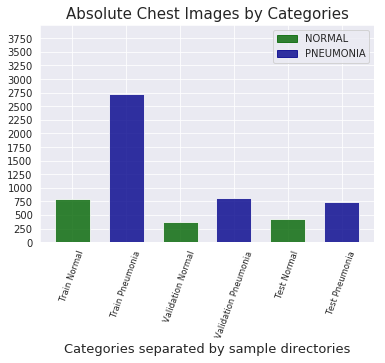

In [13]:
# Visualise all the findings
locations = [0, 1, 2, 3, 4, 5]
colors = ['darkgreen', 'darkblue', 'darkgreen', 'darkblue', 'darkgreen', 'darkblue']
hights = [count_train_normal, count_train_pneumonia, count_valid_normal, count_valid_pneumonia,
         count_test_normal, count_test_pneumonia]
width = 0.65
label_list = ['Train Normal', 'Train Pneumonia', 'Validation Normal', 'Validation Pneumonia',
              'Test Normal', 'Test Pneumonia']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

plt.yticks(np.arange(0, 4000, 250))
labels = ax.set_xticklabels(label_list, rotation=70, fontsize='small')
plt.bar(locations, hights, width, color=colors, tick_label=labels, alpha=0.8)
plt.ylim([0, 4000])
plt.title('Absolute Chest Images by Categories', fontsize=15)
plt.xlabel('Categories separated by sample directories', fontsize=13)
green_patch = mpatches.Patch(color='darkgreen', label='NORMAL', alpha=0.8)
blue_patch = mpatches.Patch(color='darkblue', label='PNEUMONIA', alpha=0.8)
plt.legend(handles = [green_patch, blue_patch])

**Note:**<br>
In each set there are much more Pneumonia cases compared to the non-Pneumonia ones, especially for the training set. So, there is a kind of imbalance.

In [14]:
# For simpler usage, first we have to put the data in a dictionary.
# {'train' : {'Normal' : count_train_normal,
#             'Pneumonia' : count_train_pneumonia},
#  'valid' : {'Normal' : count_valid_normal,
#             'Pneumonia' : count_valid_pneumonia}, 
#  'test' : {'Normal' : count_test_normal, 
#            'Pneumonia' : count_test_pneumonia}}

categories_counter_data = {"Sample" : ["train", "valid", "test"],
                           "Normal" : [count_train_normal, count_valid_normal, count_test_normal],
                           "Pneumonia" : [count_train_pneumonia, count_valid_pneumonia, count_test_pneumonia]}

df_categories = pd.DataFrame(data = categories_counter_data, index = ["train", "valid", "test"])

In [15]:
# Add the amount difference for each category and directory to the dataframe
df_categories['Difference'] = df_categories['Normal'] - df_categories['Pneumonia']

In [16]:
# Visualise the differences compared to category and sample directories,
# therefore use the absolute values of the differences as well to see them on the same positive level
df_categories['Difference_abs'] = df_categories['Difference'] * (-1)
df_categories.head()

,Normal,Pneumonia,Sample,Difference,Difference_abs
train,792,2728,train,-1936,1936
valid,362,806,valid,-444,444
test,430,741,test,-311,311


Now, the relationship of the amount difference between the normal and pneumonia samples are visualised.

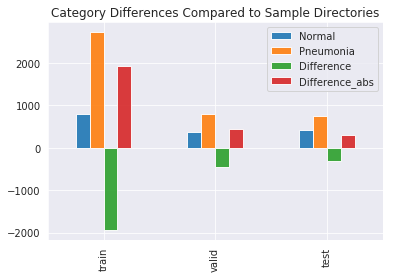

In [17]:
#locations = [0, 1, 2}
x_labels = ['Train', 'Valid', 'Test']

df_categories.plot(title='Category Differences Compared to Sample Directories', kind='bar', tick_label=x_labels, alpha=0.9)

The training set (x label: train) has much more pneumonia cases compared to the normal ones, this is not the case for the testing samples (x label: test) and the validation samples (x label: valid) of normal and pneumonia chest images. They look much more balanced.

**Additional question** regarding the different sample directories: How many of the pneumonia chest images have virus or bacteria as _root cause_?

In [18]:
def get_rootcause_counter(files):
    ''' delivers the amount of bacteria or virus pneumonia images '''
    counter_virus = 0
    counter_bacteria = 0
    file_array = files
    
    
    for item in file_array:
        if 'virus' in item:
            counter_virus += 1
        elif 'bacteria' in item:
            counter_bacteria += 1
        else:
            print('{} does not include a root cause in its file name string (virus or bac.')
            
    return counter_virus, counter_bacteria

count_train_virus, count_train_bacteria = get_rootcause_counter(train_pneumonia_files)
count_valid_virus, count_valid_bacteria = get_rootcause_counter(valid_pneumonia_files)
count_test_virus, count_test_bacteria = get_rootcause_counter(test_pneumonia_files)

print("--- Train pneumonia files ---")        
print("{} virus chest images.".format(count_train_virus))
print("{} bacteria chest images.".format(count_train_bacteria))

print("\n--- Validation pneumonia files ---")        
print("{} virus chest images.".format(count_valid_virus))
print("{} bacteria chest images.".format(count_valid_bacteria))

print("\n--- Test pneumonia files ---")        
print("{} virus chest images.".format(count_test_virus))
print("{} bacteria chest images.".format(count_test_bacteria))

--- Train pneumonia files ---
878 virus chest images.
1850 bacteria chest images.

--- Validation pneumonia files ---
358 virus chest images.
448 bacteria chest images.

--- Test pneumonia files ---
259 virus chest images.
482 bacteria chest images.


**Note:**<br>
In the future, having more pneumonia chest images with further root causes (not only virus and bacteria root causes exist), the algorithm can be improved doing a multi-class classification between normal and pneumonia ones, where the pneumonia ones are differentiated by their root cause from the scratch.

<a id='step3'></a>
## Step 3: Data Pre-Processing

Keras is using TensorFlow as backend, means as tensor manipulation. According the TensorFlow [guide](https://www.tensorflow.org/guide/tensors), a "tensor is a generalization of vectors and matrices to potentially higher dimensions. Internally, TensorFlow represents tensors as n-dimensional arrays of base datatypes." 

Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively. The channels value is 1, if the image is a grey-scale image and 3 otherwise (RGB). 


The `path_to_tensor` function below takes a string-valued file path to a grey-scale chest image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor. Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset.

In [19]:
def path_to_tensor(img_path):
    # loads image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We rescale the images by dividing every pixel in every image by 255.

In [20]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 1171/1171 [00:24<00:00, 48.37it/s]


In [21]:
print('The tensor shape of the images is:')
print('Train dataset shape: {}'.format(train_tensors.shape))
print('Validation dataset shape: {}'.format(valid_tensors.shape))
print('Test dataset shape: {}'.format(test_tensors.shape))

The tensor shape of the images is:
Train dataset shape: (3520, 224, 224, 3)
Validation dataset shape: (1168, 224, 224, 3)
Test dataset shape: (1171, 224, 224, 3)


<a id='step4'></a>
## Step 4: Create a CNN Model from the Scratch (Basic Model)

### Model Implementation

Start creating a basic model with 5 blocks of Convolutional, MaxPooling and Dropout sublayers as hidden layer components. As flatten layer GlobalAveragePooling2D is used. The output Dense layer for the 2 resulting categories NORMAL and PNEUMONIA is using 'softmax' as activation function.

In [22]:
# Define the base model architecture.
# Start with the basic model
base_model_class = Model("Basic", "Basic_CNN_Model", "accuracy")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
______________________________________

### Compile the Model

As optimiser 'rmsprop' with loss function 'binary_crossentropy' and 'accuracy' metric is used. The weights of the model layers will be updated during training.

In [23]:
base_model_class = base_model_class.get_class()
# Is it the expected class?
base_model_class

In [24]:
# use with general optimiser 'rmsprop'
base_model = base_model_class.get_model()
base_model_class.compile_model(model=base_model, optimizer='rmsprop',
                               loss='binary_crossentropy', metrics=['accuracy'])

### Train the Model

Model training with use of checkpointing to save the model that attains the best validation loss. The following hyperparameters are set: 
- `epochs` is set to a number of iterations including the point where the network stops learning or start overfitting
- `batch_size` is set to a common minimal size of memory: 32; if your machine is better use 64, 128, 256, ... 

For the modified V3 dataset: train on 132 x 32 = 3520 samples  (batch size of 32)

In [26]:
# specify the number of epochs used to train the model
# with the other distributions, no real learning appeared, therefore epochs is set to 15

base_model_history = base_model_class.train_model(model=base_model, epochs=15, batch_size=32,
                                           filepath='./saved_models/base_model_weights.best.from_scratch.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 3520 samples, validate on 1168 samples
Epoch 1/15
 - 277s - loss: 4.3571 - acc: 0.7114 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00001: val_loss improved from inf to 4.96828, saving model to ./saved_models/base_model_weights.best.from_scratch.hdf5
Epoch 2/15
 - 277s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00002: val_loss did not improve from 4.96828
Epoch 3/15
 - 277s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00003: val_loss did not improve from 4.96828
Epoch 4/15
 - 277s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00004: val_loss did not improve from 4.96828
Epoch 5/15
 - 277s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00005: val_loss did not improve from 4.96828
Epoch 6/15
 - 277s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00006: val_loss did not improve from 4.96828
Epoch 7/15
 - 277s - loss: 3.6068 - acc: 0.7750 - val_lo

**Note:**<br>
As visible on all results, the model shows high overfitting and no real learning, it cannot be used for the given task. Would this change by using this model architecture with the augmentation concept?

<a id='step5'></a>
## Step 5 Last Basic Model with Augmentation

### Model Implementation and Training

We are using image data augmentation to decrease the amount of images of our training dataset, and see if there is an improvement to reduce the existing misclassification error. This concept shall improve the performance and the generalisation ability of our network. We want to prevent overfitting. Keras offers already a process to do this, using its ImageDataGenerator object class. The original images are rotated, shifted, zoomed, flipped etc. and by doing this, creating new image mutations. So, the range of images for each epoch increases and the propability that the algorithm sees the same images more than once is much reduced.

Generator handling according the given Keras example using .flow() functionality together with the already created pre-processed tensors instances. With such tensors rescaling by /255 has already happened. The .flow() command generates batches of randomly transformed images.

The generator parameters are set according the image properties, having chest images. E.g. huge zooming or rotation would make no sense, but horizontal flip is fine. 

In general according augmentation information, have a look to the associated Keras classification [article](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [27]:
train_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    rescale=1.,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

validation_generator = ImageDataGenerator(rescale=1)

In [28]:
batch_size = 32
training_data = train_data_generator.flow(train_tensors, train_targets, batch_size=batch_size)
validation_data = validation_generator.flow(valid_tensors, valid_targets, batch_size=batch_size)

In [29]:
model = Model("Basic", "Basic_CNN_Model", "accuracy")
aug_base_model_class = model.get_class()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)          

In [30]:
aug_base_model = aug_base_model_class.get_model()
aug_base_model_class.compile_model(model=aug_base_model, optimizer='rmsprop',
                                   loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
epochs = 15
aug_base_model_history = aug_base_model_class.augmentation_train_model(model=aug_base_model,
                                  filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/15
 - 285s - loss: 3.4090 - acc: 0.7494 - val_loss: 3.7388 - val_acc: 0.6892

Epoch 00001: val_loss improved from inf to 3.73885, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 286s - loss: 3.6068 - acc: 0.7750 - val_loss: 3.6874 - val_acc: 0.6937

Epoch 00002: val_loss improved from 3.73885 to 3.68738, saving model to ./saved_models/base_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 284s - loss: 4.3172 - acc: 0.7307 - val_loss: 10.7600 - val_acc: 0.3143

Epoch 00003: val_loss did not improve from 3.68738
Epoch 4/15
 - 282s - loss: 12.4234 - acc: 0.2250 - val_loss: 10.8744 - val_acc: 0.3063

Epoch 00004: val_loss did not improve from 3.68738
Epoch 5/15
 - 282s - loss: 10.5836 - acc: 0.3398 - val_loss: 4.9953 - val_acc: 0.6884

Epoch 00005: val_loss did not improve from 3.68738
Epoch 6/15
 - 274s - loss: 3.6068 - acc: 0.7750 - val_loss: 5.1223 - val_acc: 0.6805

Epoch 00006: val_loss did not improve from 3.68738
Epoch 7/15
 - 

<a id='step6'></a>
## Step 6: Such Basic Model with Adam as Optimiser

Adam is another adaptive gradient descent algorithm. It updates the RMSProp optimiser and shall improve the task performance. Less manual tuning of the hyperparameters for the learning rate schedule is necessary.

### Compile and Train the Model

In [32]:
# Start creating as new instance with the basic model
model = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_base_model_class = model.get_class()
adam_base_model = adam_base_model_class.get_model()
adam_base_model  # must be Sequential instance


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)         

In [33]:
# adam defaults:
# keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
# learn with decay to avoid overfitting, decay=1e-6
adam_base_model_class.set_Adam_params()
adam_base_model_class.compile_model(model=adam_base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_base_model = adam_base_model_class.get_model()

In [34]:
# train the model with call of train function
adam_base_model_history = adam_base_model_class.train_model(model=adam_base_model, epochs=20, batch_size = 32,
                                  filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5',
                                  train_tensors=train_tensors, train_targets=train_targets,
                                  valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 3520 samples, validate on 1168 samples
Epoch 1/20
 - 275s - loss: 0.5431 - acc: 0.7733 - val_loss: 0.5194 - val_acc: 0.6901

Epoch 00001: val_loss improved from inf to 0.51940, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 2/20
 - 275s - loss: 0.3949 - acc: 0.8091 - val_loss: 0.4385 - val_acc: 0.7012

Epoch 00002: val_loss improved from 0.51940 to 0.43852, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 3/20
 - 274s - loss: 0.3529 - acc: 0.8222 - val_loss: 0.4565 - val_acc: 0.7046

Epoch 00003: val_loss did not improve from 0.43852
Epoch 4/20
 - 274s - loss: 0.3331 - acc: 0.8384 - val_loss: 0.4140 - val_acc: 0.7868

Epoch 00004: val_loss improved from 0.43852 to 0.41403, saving model to ./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5
Epoch 5/20
 - 274s - loss: 0.3230 - acc: 0.8415 - val_loss: 0.4006 - val_acc: 0.8031

Epoch 00005: val_loss improved from 0.41403 to 0.40064, savin

<a id='step7'></a>
## Step 7: Last Basic Model with Adam and Augmentation

### Model Implementation and Training

In [35]:
# create new instance
model = Model("Basic", "Basic_CNN_Model", "accuracy")
adam_aug_base_model_class = model.get_class()
adam_aug_base_model = adam_aug_base_model_class.get_model()


--- Build model summary of Basic_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)         

In [37]:
adam_aug_base_model_class.set_Adam_params()
adam_aug_base_model_class.compile_model(model=adam_aug_base_model, optimizer='Adam', loss='binary_crossentropy',
                                    metrics=['accuracy'])
adam_aug_base_model = adam_aug_base_model_class.get_model()

In [38]:
epochs = 20
#  still the same: batch_size = 32

# use the same generator instance and flow data as before ...
adam_aug_base_model_history = adam_aug_base_model_class.augmentation_train_model(model=adam_aug_base_model,
                                  filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5',
                                  training_data=training_data, validation_data=validation_data,
                                  epochs=epochs, batch_size=batch_size,
                                  train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/20
 - 284s - loss: 0.5450 - acc: 0.7665 - val_loss: 0.6430 - val_acc: 0.6849

Epoch 00001: val_loss improved from inf to 0.64296, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 2/20
 - 278s - loss: 0.4580 - acc: 0.7770 - val_loss: 0.6349 - val_acc: 0.6937

Epoch 00002: val_loss improved from 0.64296 to 0.63493, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 3/20
 - 270s - loss: 0.4140 - acc: 0.7756 - val_loss: 0.5151 - val_acc: 0.6866

Epoch 00003: val_loss improved from 0.63493 to 0.51510, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 4/20
 - 278s - loss: 0.3659 - acc: 0.7991 - val_loss: 0.4268 - val_acc: 0.8204

Epoch 00004: val_loss improved from 0.51510 to 0.42679, saving model to ./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5
Epoch 5/20
 - 277s - loss: 0.3302 - acc: 0.8463 - val_loss: 0.4094 - val_acc: 0.8213

Epoch 00005: val_loss 

<a id='step8'></a>
## Step 8: Create an improved CNN Model with Adam

Now, we train a model having more hidden layers - a more complex architecture - using Adam as optimiser at once, what kind of result will be calculated compared to the last basic model after having done the augmentation improvement? The Adam optimiser is used for learning with binary crossentropy loss function.

Afterwards, we apply the augmentation concept on this improved model and see what kind of performance difference will appear. Is there an improvement compared to the model architecture before?

To know more about improved model architectures the following [paper](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf) is available:
'Going Deeper with Convolutions'


### Model Implementation

In [39]:
# Define the improved model architecture.
improved_model = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model_class = improved_model.get_class()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)    

### Compile the Model

In [40]:
# first try: use Adam optimiser with decay=1e-6 
improved_model = improved_model_class.get_model()
improved_model_class.set_Adam_params()
improved_model_class.compile_model(model=improved_model, optimizer='Adam', loss='binary_crossentropy',
                                   metrics=['accuracy'])

### Train the Model

In [41]:
epochs = 15
batch_size = 32
improved_model_adam = improved_model_class.get_model()
improved_model_history = improved_model_class.train_model(model=improved_model_adam,
                                           epochs=epochs, batch_size=batch_size,
                                           filepath='./saved_models/improved_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_tensors, train_targets=train_targets,
                                           valid_tensors=valid_tensors, valid_targets=valid_targets)

Train on 3520 samples, validate on 1168 samples
Epoch 1/15
 - 507s - loss: 3.4728 - acc: 0.7656 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00001: val_loss improved from inf to 4.96828, saving model to ./saved_models/improved_model_weights.best.withAdam.hdf5
Epoch 2/15
 - 507s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00002: val_loss did not improve from 4.96828
Epoch 3/15
 - 507s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00003: val_loss did not improve from 4.96828
Epoch 4/15
 - 507s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00004: val_loss did not improve from 4.96828
Epoch 5/15
 - 507s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00005: val_loss did not improve from 4.96828
Epoch 6/15
 - 507s - loss: 3.6068 - acc: 0.7750 - val_loss: 4.9683 - val_acc: 0.6901

Epoch 00006: val_loss did not improve from 4.96828
Epoch 7/15
 - 507s - loss: 3.6068 - acc: 0.7750 - val_lo

In [ ]:
# plot the improved model to a file and store it for further usage (only first time)
#plot_model(improved_model_adam, to_file='./saved_models/improved_model_withAdam.png')

<a id='step9'></a>
## Step 9:  Last improved CNN Model with Augmentation

We use the same ImageDataGenerator instance and flow function results as before.

In [42]:
# new instance learning on the same dataset with augmentation
improved_model_aug = Model("Improved", "Improved_CNN_Model", "accuracy")
improved_model_aug_class = improved_model_aug.get_class()


--- Build model summary of Improved_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 111, 111, 32)      4128      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)    

### Compile the Model

In [43]:
improved_model_aug = improved_model_aug_class.get_model()
improved_model_aug_class.set_Adam_params(lr=1e-4) # there has been no real learning improvement with the former model
improved_model_aug_class.compile_model(model=improved_model_aug, optimizer='Adam', loss='binary_crossentropy',
                                       metrics=['accuracy'])

### Training with Augmentation

In [44]:
# because the former model does not learn during its training sequence, reduce to 15
# the learning rate is already reduced to lr=1e-4 compared to the default value lr=0.001 used before with the former model
epochs = 15  
batch_size = 32
# generator and generator flow data, training and validation data are the same as before

improved_model_aug_history = improved_model_aug_class.augmentation_train_model(model=improved_model_aug,
                                filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors, valid_tensors=valid_tensors)

Epoch 1/15
 - 514s - loss: 0.5517 - acc: 0.7693 - val_loss: 0.6546 - val_acc: 0.6998

Epoch 00001: val_loss improved from inf to 0.65460, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 512s - loss: 0.5407 - acc: 0.7759 - val_loss: 0.6460 - val_acc: 0.6981

Epoch 00002: val_loss improved from 0.65460 to 0.64596, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 3/15
 - 510s - loss: 0.5417 - acc: 0.7730 - val_loss: 0.6457 - val_acc: 0.6743

Epoch 00003: val_loss improved from 0.64596 to 0.64572, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 4/15
 - 513s - loss: 0.5406 - acc: 0.7727 - val_loss: 0.6437 - val_acc: 0.6945

Epoch 00004: val_loss improved from 0.64572 to 0.64368, saving model to ./saved_models/improved_model_weights.best.withAugmentation.hdf5
Epoch 5/15
 - 510s - loss: 0.5360 - acc: 0.7753 - val_loss: 0.6357 - val_acc: 0.6910

Epoch 00005: val_loss impr

<a id='step10'></a>
## Step 10: Create a ResNet CNN Model with Transfer Learning

As sense of transfer learning, Goodfellow et al mentioned in their 'Deep Learning' book "Situation where what has been learned in one setting is exploited to improve generalization in another setting."

We don't have a huge dataset for the given pneumonia classification and more generalised, even not for all human age and X-ray orientation categories. The existing dataset is a specific one for a specific task, therefore we need technical help to improve the classification performance having a good, proper learning result, especially thinking at the 'new, available' image examples of the future.

With a pre-trained model, we use its knowledge even from another domain and task (like for image tasks a pre-trained model from the huge ImageNet database including a lot of different object categories), to let our network learn the new problem. This knowledge transfer is possible, because all images share some same features, like e.g. edges, shapes, zooming or rotation. The common features are learned in the hidden layers from the beginning, the more specific task ones are learned at the end of the hidden layer blocks. To improve our specific classification task we can change the network there and let the first part as learned with the ImageNet database. We don't need our network to learn from scratch. We can freeze such hidden-layer convolutional subblocks and its outputs are the input of the specific classifier block at the end of the network.

Technically, how to do this is e.g. explained in the Keras [documentation](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).


### Model Implementation and Compilation

First, we create a pre-trained ResNet50 CNN model and freeze the convolution blocks, so that we can use it as an image feature extractor to get the bottleneck features. ResNet is a short name for residual network. It includes a lot of subblocks with BatchNormalization layers.

In [45]:
basic_resNet_model = Model("Transfer", "Transfer_ResNet_CNN_Model", "accuracy")
#print(resNet_model)
basic_resNet_model_class = basic_resNet_model.get_class()
#print(resNet_model_class)
input_shape = (224, 224, 3) # see info after tensor creation above
basic_resNet_model_class.build_model_feature_extractor(input_shape=input_shape)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



--- Build model summary of RestNet Transfer_CNN_Model as feature extractor: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________

In [46]:
# plot the transfer model to a file and store it for further usage
basic_resNet_model = basic_resNet_model_class.get_model()

# plotting only first time
#plot_model(basic_resNet_model, to_file='./saved_models/resNet_transfer_model_withoutTopLayer.png')

In [47]:
# print the status
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in basic_resNet_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7faa244a0588>,input_1,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7faa244a0898>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7faa1cde0f98>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7faa1c2831d0>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7faa1d8d6470>,activation_1,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7faa1d93ab70>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7faa1d93a198>,max_pooling2d_33,False
7,<keras.layers.convolutional.Conv2D object at 0x7faa1d8e5cc0>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7faa1c1e8c50>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7faa1c1e8ba8>,activation_2,False


The last activation feature map of our ResNet CNN model delivers the bottleneck features. They are the input for the flatten layer and used for our specific, final CNN network layer.

In [48]:
#
# if you create the bottleneck features the first time, we need this function; but
# if they are already created and stored skip this creation part and go to the part after npzfile.close()
#
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [49]:
print('--- Create bottleneck features for train tensors images ---')
train_resNet = get_bottleneck_features(basic_resNet_model, train_tensors)
print('--- Create bottleneck features for validation tensors images ---')
valid_resNet = get_bottleneck_features(basic_resNet_model, valid_tensors)
print('--- Create bottleneck features for test tensors images ---')
test_resNet = get_bottleneck_features(basic_resNet_model, test_tensors)

--- Create bottleneck features for train tensors images ---
--- Create bottleneck features for validation tensors images ---
--- Create bottleneck features for test tensors images ---


In [50]:
print('RestNet50 train bottleneck features: {}'.format(train_resNet.shape))
print('RestNet50 validation bottleneck features: {}'.format(valid_resNet.shape))
print('RestNet50 test bottleneck features: {}'.format(test_resNet.shape))

RestNet50 train bottleneck features: (3520, 2048)
RestNet50 validation bottleneck features: (1168, 2048)
RestNet50 test bottleneck features: (1171, 2048)


**Note:**<br>
So, our bottleneck features have a dimension of 1x2048. Our new network architecture is taking this bottleneck vectors as input.

In [51]:
valid_resNet

array([[0.       , 0.       , 0.       , ..., 1.8497019, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.0452664, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.0349035, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 2.0073757, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.960201 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8875729, 0.       ,
        0.       ]], dtype=float32)

In [52]:
# store the bottleneck files
np.savez('./bottleneck_features/chest_ResNet50_features.npz',
         train=train_resNet, valid=valid_resNet, test=test_resNet)

In [53]:
# test about files, dont' forget to close the file instance
npzfile = np.load('./bottleneck_features/chest_ResNet50_features.npz')
npzfile.files

['test', 'train', 'valid']

In [54]:
npzfile['valid']

array([[0.       , 0.       , 0.       , ..., 1.8497019, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.0452664, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 2.0349035, 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 2.0073757, 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.960201 , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.8875729, 0.       ,
        0.       ]], dtype=float32)

In [55]:
npzfile.close()

Now, after having stored the bottleneck features of the train, valid and test tensors, we can build our final CNN architecture, means we add the top layer to the existing ResNet model.

As a top model construction a flatten GlobalAveragePooling2D layer, followed by a BatchNormalization instance and the fully connected Dense layer, which handles the 2 different X-ray chest images categories, are used.

In [56]:
#
# if the bottleneck feature file is already stored and this python project runs again ... 
# use this lines of code to get the bottleneck features for the train, valid and test samples
#
bottleneck_features = np.load('./bottleneck_features/chest_ResNet50_features.npz')
train_resNet = bottleneck_features['train']
valid_resNet = bottleneck_features['valid']
test_resNet = bottleneck_features['test']
bottleneck_features.close()

In [57]:
# build the final CNN architecture with added top layer part
basic_resNet_model_class.build_model(basic_resNet_model)
basic_resNet_model = basic_resNet_model_class.get_model()


--- Build model summary of final RestNet Transfer_CNN_Model with top layer: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 4098      
Total params: 12,290
Trainable params: 8,194
Non-trainable params: 4,096
_________________________________________________________________


In [58]:
# let's train the final transfer learning model using Adam with decay 1e-6 for each learning update and 
# a smaller learning rate to avoid to get stuck in a local minimum and to reduce overfitting
basic_resNet_model_class.set_Adam_params(lr=1e-4)
basic_resNet_model_class.compile_model(model=basic_resNet_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [59]:
epochs = 300  # fast training compared the previous models
batch_size = 32
basic_resNet_model = basic_resNet_model_class.get_model()
resNet_transfer_model_history = basic_resNet_model_class.train_model(model=basic_resNet_model,
                                  filepath='./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_resNet, train_targets=train_targets,
                                           valid_tensors=valid_resNet, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

Train on 3520 samples, validate on 1168 samples
Epoch 1/300
 - 2s - loss: 0.5466 - acc: 0.7344 - val_loss: 0.4166 - val_acc: 0.8245

Epoch 00001: val_loss improved from inf to 0.41657, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 2/300
 - 0s - loss: 0.3542 - acc: 0.8452 - val_loss: 0.3621 - val_acc: 0.8236

Epoch 00002: val_loss improved from 0.41657 to 0.36206, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 3/300
 - 0s - loss: 0.3189 - acc: 0.8599 - val_loss: 0.3303 - val_acc: 0.8476

Epoch 00003: val_loss improved from 0.36206 to 0.33035, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 4/300
 - 0s - loss: 0.2951 - acc: 0.8696 - val_loss: 0.3157 - val_acc: 0.8553

Epoch 00004: val_loss improved from 0.33035 to 0.31565, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 5/300
 - 0s - loss: 0.2766 - acc: 0.8787 - val_loss: 0.292

 - 0s - loss: 0.1274 - acc: 0.9545 - val_loss: 0.1420 - val_acc: 0.9555

Epoch 00039: val_loss improved from 0.14432 to 0.14204, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 40/300
 - 0s - loss: 0.1307 - acc: 0.9560 - val_loss: 0.1417 - val_acc: 0.9572

Epoch 00040: val_loss improved from 0.14204 to 0.14170, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 41/300
 - 0s - loss: 0.1271 - acc: 0.9545 - val_loss: 0.1410 - val_acc: 0.9546

Epoch 00041: val_loss improved from 0.14170 to 0.14099, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 42/300
 - 0s - loss: 0.1279 - acc: 0.9520 - val_loss: 0.1402 - val_acc: 0.9555

Epoch 00042: val_loss improved from 0.14099 to 0.14020, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 43/300
 - 0s - loss: 0.1246 - acc: 0.9562 - val_loss: 0.1388 - val_acc: 0.9580

Epoch 00043: val_loss improved 

 - 0s - loss: 0.0982 - acc: 0.9653 - val_loss: 0.1142 - val_acc: 0.9606

Epoch 00085: val_loss improved from 0.11435 to 0.11423, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 86/300
 - 0s - loss: 0.1004 - acc: 0.9619 - val_loss: 0.1148 - val_acc: 0.9606

Epoch 00086: val_loss did not improve from 0.11423
Epoch 87/300
 - 0s - loss: 0.1042 - acc: 0.9597 - val_loss: 0.1155 - val_acc: 0.9632

Epoch 00087: val_loss did not improve from 0.11423
Epoch 88/300
 - 0s - loss: 0.1012 - acc: 0.9639 - val_loss: 0.1122 - val_acc: 0.9623

Epoch 00088: val_loss improved from 0.11423 to 0.11222, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 89/300
 - 0s - loss: 0.1023 - acc: 0.9628 - val_loss: 0.1139 - val_acc: 0.9615

Epoch 00089: val_loss did not improve from 0.11222
Epoch 90/300
 - 0s - loss: 0.0961 - acc: 0.9673 - val_loss: 0.1156 - val_acc: 0.9632

Epoch 00090: val_loss did not improve from 0.11222
Epoch 91/300
 - 0

 - 0s - loss: 0.0856 - acc: 0.9688 - val_loss: 0.1031 - val_acc: 0.9649

Epoch 00134: val_loss improved from 0.10327 to 0.10306, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 135/300
 - 0s - loss: 0.0887 - acc: 0.9673 - val_loss: 0.1043 - val_acc: 0.9632

Epoch 00135: val_loss did not improve from 0.10306
Epoch 136/300
 - 0s - loss: 0.0914 - acc: 0.9642 - val_loss: 0.1023 - val_acc: 0.9658

Epoch 00136: val_loss improved from 0.10306 to 0.10230, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 137/300
 - 0s - loss: 0.0880 - acc: 0.9673 - val_loss: 0.1047 - val_acc: 0.9640

Epoch 00137: val_loss did not improve from 0.10230
Epoch 138/300
 - 0s - loss: 0.0870 - acc: 0.9696 - val_loss: 0.1027 - val_acc: 0.9649

Epoch 00138: val_loss did not improve from 0.10230
Epoch 139/300
 - 0s - loss: 0.0847 - acc: 0.9688 - val_loss: 0.1032 - val_acc: 0.9632

Epoch 00139: val_loss did not improve from 0.10230
Epoch 140/30


Epoch 00185: val_loss did not improve from 0.09641
Epoch 186/300
 - 0s - loss: 0.0765 - acc: 0.9722 - val_loss: 0.0989 - val_acc: 0.9632

Epoch 00186: val_loss did not improve from 0.09641
Epoch 187/300
 - 0s - loss: 0.0800 - acc: 0.9696 - val_loss: 0.0965 - val_acc: 0.9700

Epoch 00187: val_loss did not improve from 0.09641
Epoch 188/300
 - 0s - loss: 0.0770 - acc: 0.9705 - val_loss: 0.0958 - val_acc: 0.9709

Epoch 00188: val_loss improved from 0.09641 to 0.09580, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 189/300
 - 0s - loss: 0.0781 - acc: 0.9724 - val_loss: 0.0958 - val_acc: 0.9692

Epoch 00189: val_loss did not improve from 0.09580
Epoch 190/300
 - 0s - loss: 0.0807 - acc: 0.9699 - val_loss: 0.0959 - val_acc: 0.9709

Epoch 00190: val_loss did not improve from 0.09580
Epoch 191/300
 - 0s - loss: 0.0747 - acc: 0.9727 - val_loss: 0.0987 - val_acc: 0.9632

Epoch 00191: val_loss did not improve from 0.09580
Epoch 192/300
 - 0s - loss: 0.078


Epoch 00239: val_loss improved from 0.09239 to 0.09214, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5
Epoch 240/300
 - 0s - loss: 0.0781 - acc: 0.9699 - val_loss: 0.0928 - val_acc: 0.9692

Epoch 00240: val_loss did not improve from 0.09214
Epoch 241/300
 - 0s - loss: 0.0682 - acc: 0.9753 - val_loss: 0.0932 - val_acc: 0.9692

Epoch 00241: val_loss did not improve from 0.09214
Epoch 242/300
 - 0s - loss: 0.0745 - acc: 0.9710 - val_loss: 0.0934 - val_acc: 0.9692

Epoch 00242: val_loss did not improve from 0.09214
Epoch 243/300
 - 0s - loss: 0.0724 - acc: 0.9747 - val_loss: 0.0932 - val_acc: 0.9692

Epoch 00243: val_loss did not improve from 0.09214
Epoch 244/300
 - 0s - loss: 0.0756 - acc: 0.9682 - val_loss: 0.0960 - val_acc: 0.9658

Epoch 00244: val_loss did not improve from 0.09214
Epoch 245/300
 - 0s - loss: 0.0699 - acc: 0.9736 - val_loss: 0.0931 - val_acc: 0.9717

Epoch 00245: val_loss did not improve from 0.09214
Epoch 246/300
 - 0s - loss: 0.068


Epoch 00295: val_loss did not improve from 0.09023
Epoch 296/300
 - 0s - loss: 0.0678 - acc: 0.9747 - val_loss: 0.0906 - val_acc: 0.9692

Epoch 00296: val_loss did not improve from 0.09023
Epoch 297/300
 - 0s - loss: 0.0673 - acc: 0.9747 - val_loss: 0.0906 - val_acc: 0.9692

Epoch 00297: val_loss did not improve from 0.09023
Epoch 298/300
 - 0s - loss: 0.0623 - acc: 0.9790 - val_loss: 0.0906 - val_acc: 0.9700

Epoch 00298: val_loss did not improve from 0.09023
Epoch 299/300
 - 0s - loss: 0.0645 - acc: 0.9776 - val_loss: 0.0924 - val_acc: 0.9683

Epoch 00299: val_loss did not improve from 0.09023
Epoch 300/300
 - 0s - loss: 0.0648 - acc: 0.9753 - val_loss: 0.0898 - val_acc: 0.9692

Epoch 00300: val_loss improved from 0.09023 to 0.08979, saving model to ./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5


In [ ]:
# plot the top layer of the transfer model to a file and store it for further usage (only first time)
#plot_model(resNet_model, to_file='./saved_models/resNet_transfer_model_topLayer.png')

<a id='step11'></a>
## Step 11: Fine-tuned Transfer Learning ResNet CNN Model with Augmentation

Now, we unfreeze the last res5c layer block of the formerly created transfer learning CNN model build architecture. There, the layer weights will be updated in each epoch as we pass the data batch. The training is implemented to use the augmentation concept with generators as before.

In [60]:
resNet_model = Model("Transfer", "Transfer_ResNet_CNN_Model", "accuracy")
resNet_ft_model_class = resNet_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
resNet_ft_model = resNet_ft_model_class.build_finetuned_model(input_shape=input_shape)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



--- Build model summary of fine-tuned RestNet Transfer_CNN_Model: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________________________

In [61]:
# print the status        
layers = [(layer, layer.name, layer.trainable) for layer in resNet_ft_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fa9eedf6160>,input_3,False
1,<keras.layers.convolutional.ZeroPadding2D object at 0x7faa244a03c8>,conv1_pad,False
2,<keras.layers.convolutional.Conv2D object at 0x7fa9eea34da0>,conv1,False
3,<keras.layers.normalization.BatchNormalization object at 0x7fa9ee9d0470>,bn_conv1,False
4,<keras.layers.core.Activation object at 0x7fa9ee9edeb8>,activation_50,False
5,<keras.layers.convolutional.ZeroPadding2D object at 0x7fa9ee991cc0>,pool1_pad,False
6,<keras.layers.pooling.MaxPooling2D object at 0x7fa9ee9a6470>,max_pooling2d_34,False
7,<keras.layers.convolutional.Conv2D object at 0x7fa9ee9805f8>,res2a_branch2a,False
8,<keras.layers.normalization.BatchNormalization object at 0x7fa9ee8e6278>,bn2a_branch2a,False
9,<keras.layers.core.Activation object at 0x7fa9ee8e6828>,activation_51,False


### Compile and Train the Model

In [62]:
resNet_ft_model_class.build_ResNet_aug_model(resNet_ft_model)
resNet_ft_model = resNet_ft_model_class.get_model()
resNet_ft_model_class.set_Adam_params(lr=1e-4)
resNet_ft_model_class.compile_model(model= resNet_ft_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])


--- Build model summary of augmented RestNet Transfer_CNN_Model: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Model)              (None, 2048)              23587712  
_________________________________________________________________
input_4 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 4098      
Total params: 23,600,002
Trainable params: 4,473,858
Non-trainable params: 19,126,144
_________________________________________________________________


In [76]:
epochs = 15  # very slow training, because of experience with original dataset changed from 20 to 15
batch_size = 32
# generator and generator flow data, training and validation data are the same as before;
# because of augmentation concept, bottleneck features are not used

resNet_finetuned_model_aug_history = resNet_ft_model_class.augmentation_train_model(model=resNet_ft_model,
               filepath='./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5', 
                                training_data=training_data, validation_data=validation_data,
                                epochs=epochs, batch_size=batch_size,
                                train_tensors=train_tensors,
                                valid_tensors=valid_tensors)

Epoch 1/15
 - 2140s - loss: 0.3615 - acc: 0.8705 - val_loss: 0.6525 - val_acc: 0.6989

Epoch 00001: val_loss improved from inf to 0.65255, saving model to ./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5
Epoch 2/15
 - 2126s - loss: 0.1539 - acc: 0.9548 - val_loss: 0.6807 - val_acc: 0.6769

Epoch 00002: val_loss did not improve from 0.65255
Epoch 3/15
 - 2123s - loss: 0.1362 - acc: 0.9625 - val_loss: 0.7317 - val_acc: 0.7069

Epoch 00003: val_loss did not improve from 0.65255
Epoch 4/15
 - 2124s - loss: 0.1194 - acc: 0.9628 - val_loss: 0.8899 - val_acc: 0.6893

Epoch 00004: val_loss did not improve from 0.65255
Epoch 5/15
 - 2132s - loss: 0.1108 - acc: 0.9670 - val_loss: 0.8354 - val_acc: 0.6805

Epoch 00005: val_loss did not improve from 0.65255
Epoch 6/15
 - 2124s - loss: 0.0955 - acc: 0.9702 - val_loss: 0.6860 - val_acc: 0.6901

Epoch 00006: val_loss did not improve from 0.65255
Epoch 7/15
 - 2124s - loss: 0.0989 - acc: 0.9713 - val_loss: 0.8382 - v

**Note:**<br>
As we can see already now, there is no classification performance improvement by using a fine-tuned model architecture.

<a id='step12'></a>
## Step 12: Create an InceptionV3 CNN Model with Transfer Learning

Keras InceptionV3 model is one of the models to classify images. It has already been trained on the huge image database ImageNet, therefore optimized filter weights ('bottleneck features') are available for input usage of a top model layer. The concept of the inception module focuses on the kernel size of convolutional layers as e.g. described in the paper ['Going deeper with convolutions'](https://arxiv.org/pdf/1409.4842.pdf).

This concept is much better according test accuracy compared with the results of the creation of a model architecture from the scratch as at the beginning of this project. There for the basic model no pre-trained information is available.<br>
For this project, the transfer learning concept has been chosen too on an InceptionV3 CNN instance as basic architecture together with its bottleneck features. As a top model construction a flatten GlobalAveragePooling2D layer, followed by a BatchNormalization instance and the fully connected Dense layer, which handles the 2 different chest categories.

### Model Implementation and Compilation

Again, we create a pre-trained InceptionV3 CNN model and freeze the convolution blocks, so that we can use it as an image feature extractor to get the bottleneck features.

In [63]:
inception_model = Model("Transfer", "Transfer_InceptionV3_CNN_Model", "accuracy")
inception_model_class = inception_model.get_class()
input_shape = (224, 224, 3) # see info after tensor creation above
inception_model_class.build_model_feature_extractor(input_shape=input_shape)


--- Build model summary of InceptionV3 Transfer_CNN_Model as feature extractor: ---
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 111, 111, 32) 96          conv2d_43[0][0]                  
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 111, 111, 32) 0           batch_normalization_3[0][0]      
________________________

In [64]:
# plot the transfer model to a file and store it for further usage
inception_model = inception_model_class.get_model()

# plotting the model only first time
#plot_model(inception_model, to_file='./saved_models/inception_transfer_model_withoutTopLayer.png')

In [65]:
# print the status
pd.set_option('max_colwidth', -1)
layers = [(layer, layer.name, layer.trainable) for layer in inception_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fa9eedf61d0>,input_5,False
1,<keras.layers.convolutional.Conv2D object at 0x7fa9b28c37f0>,conv2d_43,False
2,<keras.layers.normalization.BatchNormalization object at 0x7fa9b27e3d30>,batch_normalization_3,False
3,<keras.layers.core.Activation object at 0x7fa9b27fdb38>,activation_99,False
4,<keras.layers.convolutional.Conv2D object at 0x7fa9b27afc50>,conv2d_44,False
5,<keras.layers.normalization.BatchNormalization object at 0x7fa9b275e860>,batch_normalization_4,False
6,<keras.layers.core.Activation object at 0x7fa9b275e6a0>,activation_100,False
7,<keras.layers.convolutional.Conv2D object at 0x7fa9b26828d0>,conv2d_45,False
8,<keras.layers.normalization.BatchNormalization object at 0x7fa9b2650828>,batch_normalization_5,False
9,<keras.layers.core.Activation object at 0x7fa9b2650908>,activation_101,False


In [66]:
# bottleneck feature function is already defined above
print('--- Create bottleneck features for train tensors images ---')
train_inception = get_bottleneck_features(inception_model, train_tensors)
print('--- Create bottleneck features for validation tensors images ---')
valid_inception = get_bottleneck_features(inception_model, valid_tensors)
print('--- Create bottleneck features for test tensors images ---')
test_inception = get_bottleneck_features(inception_model, test_tensors)

--- Create bottleneck features for train tensors images ---
--- Create bottleneck features for validation tensors images ---
--- Create bottleneck features for test tensors images ---


In [67]:
# store the bottleneck files
np.savez('./bottleneck_features/chest_InceptionV3_features.npz',
         train=train_inception, valid=valid_inception, test=test_inception)

In [68]:
# test about files, dont' forget to close the file instance
npzfile = np.load('./bottleneck_features/chest_InceptionV3_features.npz')
npzfile.files

['test', 'train', 'valid']

In [69]:
print('InceptionV3 train bottleneck features: {}'.format(train_inception.shape))
print('InceptionV3 validation bottleneck features: {}'.format(valid_inception.shape))
print('InceptionV3 test bottleneck features: {}'.format(test_inception.shape))

InceptionV3 train bottleneck features: (3520, 2048)
InceptionV3 validation bottleneck features: (1168, 2048)
InceptionV3 test bottleneck features: (1171, 2048)


In [70]:
npzfile['valid']

array([[0.33712396, 0.39474946, 1.5731715 , ..., 0.2998035 , 0.0411045 ,
        1.155712  ],
       [0.2839436 , 0.01819307, 0.06920068, ..., 0.3965449 , 0.00810949,
        2.3709776 ],
       [0.06484305, 0.00790865, 0.1281889 , ..., 0.06894357, 0.10505646,
        1.0949681 ],
       ...,
       [0.41236916, 0.06653052, 0.10411844, ..., 0.3288502 , 0.06459534,
        1.3342701 ],
       [0.11652835, 0.12016542, 0.        , ..., 0.1641608 , 0.00387593,
        0.58094   ],
       [0.24596393, 0.09355435, 0.3180822 , ..., 1.2017455 , 0.08988428,
        0.5283393 ]], dtype=float32)

In [71]:
npzfile.close()

In [72]:
#
# if the bottleneck feature file is already stored and this python project runs again ... 
# use this lines of code to get the bottleneck features for the train, valid and test samples
#
bottleneck_features = np.load('./bottleneck_features/chest_InceptionV3_features.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']
bottleneck_features.close()

In [73]:
# build the final CNN architecture with added top layer part
inception_model_class.build_model(inception_model)
inception_model = inception_model_class.get_model()


--- Build model summary of final RestNet Transfer_CNN_Model with top layer: ---
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_97 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 4098      
Total params: 12,290
Trainable params: 8,194
Non-trainable params: 4,096
_________________________________________________________________


In [74]:
# let's train the final transfer learning model using Adam with decay 1e-6 for each learning update and 
# a smaller learning rate than before to avoid to get stuck in a local minimum and to reduce overfitting;
inception_model_class.set_Adam_params(lr=1e-4)
inception_model_class.compile_model(model= inception_model, loss='binary_crossentropy',
                                 optimizer='Adam', metrics=['accuracy'])

### Train the Model

In [75]:
epochs = 300  # fast training
batch_size = 32
inception_model = inception_model_class.get_model()
inception_transfer_model_history = inception_model_class.train_model(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5',
                                           train_tensors=train_inception, train_targets=train_targets,
                                           valid_tensors=valid_inception, valid_targets=valid_targets,
                                           epochs=epochs, batch_size=batch_size)

Train on 3520 samples, validate on 1168 samples
Epoch 1/300
 - 7s - loss: 0.4968 - acc: 0.7639 - val_loss: 0.3560 - val_acc: 0.8493

Epoch 00001: val_loss improved from inf to 0.35602, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 2/300
 - 0s - loss: 0.2929 - acc: 0.8844 - val_loss: 0.2566 - val_acc: 0.8973

Epoch 00002: val_loss improved from 0.35602 to 0.25662, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 3/300
 - 0s - loss: 0.2163 - acc: 0.9165 - val_loss: 0.2115 - val_acc: 0.9152

Epoch 00003: val_loss improved from 0.25662 to 0.21149, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 4/300
 - 0s - loss: 0.1792 - acc: 0.9364 - val_loss: 0.1882 - val_acc: 0.9255

Epoch 00004: val_loss improved from 0.21149 to 0.18818, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 5/300
 - 0s - loss: 0.1600 - acc: 0.9440 - val

 - 0s - loss: 0.0519 - acc: 0.9827 - val_loss: 0.1131 - val_acc: 0.9563

Epoch 00045: val_loss did not improve from 0.11154
Epoch 46/300
 - 0s - loss: 0.0514 - acc: 0.9838 - val_loss: 0.1147 - val_acc: 0.9563

Epoch 00046: val_loss did not improve from 0.11154
Epoch 47/300
 - 0s - loss: 0.0545 - acc: 0.9804 - val_loss: 0.1125 - val_acc: 0.9555

Epoch 00047: val_loss did not improve from 0.11154
Epoch 48/300
 - 0s - loss: 0.0519 - acc: 0.9838 - val_loss: 0.1168 - val_acc: 0.9478

Epoch 00048: val_loss did not improve from 0.11154
Epoch 49/300
 - 0s - loss: 0.0478 - acc: 0.9866 - val_loss: 0.1113 - val_acc: 0.9546

Epoch 00049: val_loss improved from 0.11154 to 0.11134, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 50/300
 - 0s - loss: 0.0481 - acc: 0.9821 - val_loss: 0.1099 - val_acc: 0.9572

Epoch 00050: val_loss improved from 0.11134 to 0.10995, saving model to ./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5
Epoch 51/30


Epoch 00102: val_loss did not improve from 0.10981
Epoch 103/300
 - 0s - loss: 0.0273 - acc: 0.9923 - val_loss: 0.1152 - val_acc: 0.9529

Epoch 00103: val_loss did not improve from 0.10981
Epoch 104/300
 - 0s - loss: 0.0265 - acc: 0.9923 - val_loss: 0.1155 - val_acc: 0.9580

Epoch 00104: val_loss did not improve from 0.10981
Epoch 105/300
 - 0s - loss: 0.0266 - acc: 0.9932 - val_loss: 0.1165 - val_acc: 0.9589

Epoch 00105: val_loss did not improve from 0.10981
Epoch 106/300
 - 0s - loss: 0.0302 - acc: 0.9903 - val_loss: 0.1164 - val_acc: 0.9529

Epoch 00106: val_loss did not improve from 0.10981
Epoch 107/300
 - 0s - loss: 0.0255 - acc: 0.9932 - val_loss: 0.1168 - val_acc: 0.9521

Epoch 00107: val_loss did not improve from 0.10981
Epoch 108/300
 - 0s - loss: 0.0259 - acc: 0.9929 - val_loss: 0.1168 - val_acc: 0.9538

Epoch 00108: val_loss did not improve from 0.10981
Epoch 109/300
 - 0s - loss: 0.0275 - acc: 0.9926 - val_loss: 0.1162 - val_acc: 0.9589

Epoch 00109: val_loss did not imp

 - 0s - loss: 0.0185 - acc: 0.9946 - val_loss: 0.1214 - val_acc: 0.9538

Epoch 00162: val_loss did not improve from 0.10981
Epoch 163/300
 - 0s - loss: 0.0212 - acc: 0.9949 - val_loss: 0.1229 - val_acc: 0.9546

Epoch 00163: val_loss did not improve from 0.10981
Epoch 164/300
 - 0s - loss: 0.0214 - acc: 0.9957 - val_loss: 0.1212 - val_acc: 0.9529

Epoch 00164: val_loss did not improve from 0.10981
Epoch 165/300
 - 0s - loss: 0.0150 - acc: 0.9977 - val_loss: 0.1234 - val_acc: 0.9529

Epoch 00165: val_loss did not improve from 0.10981
Epoch 166/300
 - 0s - loss: 0.0171 - acc: 0.9955 - val_loss: 0.1253 - val_acc: 0.9529

Epoch 00166: val_loss did not improve from 0.10981
Epoch 167/300
 - 0s - loss: 0.0164 - acc: 0.9960 - val_loss: 0.1250 - val_acc: 0.9538

Epoch 00167: val_loss did not improve from 0.10981
Epoch 168/300
 - 0s - loss: 0.0207 - acc: 0.9929 - val_loss: 0.1217 - val_acc: 0.9538

Epoch 00168: val_loss did not improve from 0.10981
Epoch 169/300
 - 0s - loss: 0.0168 - acc: 0.9963


Epoch 00221: val_loss did not improve from 0.10981
Epoch 222/300
 - 0s - loss: 0.0114 - acc: 0.9977 - val_loss: 0.1279 - val_acc: 0.9503

Epoch 00222: val_loss did not improve from 0.10981
Epoch 223/300
 - 0s - loss: 0.0139 - acc: 0.9974 - val_loss: 0.1255 - val_acc: 0.9555

Epoch 00223: val_loss did not improve from 0.10981
Epoch 224/300
 - 0s - loss: 0.0135 - acc: 0.9963 - val_loss: 0.1258 - val_acc: 0.9521

Epoch 00224: val_loss did not improve from 0.10981
Epoch 225/300
 - 0s - loss: 0.0141 - acc: 0.9963 - val_loss: 0.1273 - val_acc: 0.9521

Epoch 00225: val_loss did not improve from 0.10981
Epoch 226/300
 - 0s - loss: 0.0160 - acc: 0.9949 - val_loss: 0.1274 - val_acc: 0.9521

Epoch 00226: val_loss did not improve from 0.10981
Epoch 227/300
 - 0s - loss: 0.0123 - acc: 0.9977 - val_loss: 0.1260 - val_acc: 0.9546

Epoch 00227: val_loss did not improve from 0.10981
Epoch 228/300
 - 0s - loss: 0.0137 - acc: 0.9960 - val_loss: 0.1232 - val_acc: 0.9538

Epoch 00228: val_loss did not imp

 - 0s - loss: 0.0081 - acc: 0.9989 - val_loss: 0.1319 - val_acc: 0.9555

Epoch 00281: val_loss did not improve from 0.10981
Epoch 282/300
 - 0s - loss: 0.0121 - acc: 0.9966 - val_loss: 0.1302 - val_acc: 0.9546

Epoch 00282: val_loss did not improve from 0.10981
Epoch 283/300
 - 0s - loss: 0.0104 - acc: 0.9980 - val_loss: 0.1357 - val_acc: 0.9486

Epoch 00283: val_loss did not improve from 0.10981
Epoch 284/300
 - 0s - loss: 0.0113 - acc: 0.9966 - val_loss: 0.1333 - val_acc: 0.9512

Epoch 00284: val_loss did not improve from 0.10981
Epoch 285/300
 - 0s - loss: 0.0094 - acc: 0.9974 - val_loss: 0.1339 - val_acc: 0.9503

Epoch 00285: val_loss did not improve from 0.10981
Epoch 286/300
 - 0s - loss: 0.0105 - acc: 0.9989 - val_loss: 0.1315 - val_acc: 0.9546

Epoch 00286: val_loss did not improve from 0.10981
Epoch 287/300
 - 0s - loss: 0.0103 - acc: 0.9983 - val_loss: 0.1288 - val_acc: 0.9555

Epoch 00287: val_loss did not improve from 0.10981
Epoch 288/300
 - 0s - loss: 0.0096 - acc: 0.9977

In [ ]:
# plot the transfer model to a file and store it for further usage (only first time)
#plot_model(inception_model, to_file='./saved_models/inception_transfer_model_topLayer.png')

<a id='step13'></a>
## Step 13: Evaluation

### Load the Models with the Best Validation Loss

In [77]:
base_model_class.load_best_weights(model=base_model,
                                   filepath='./saved_models/base_model_weights.best.from_scratch.hdf5')
aug_base_model_class.load_best_weights(model=aug_base_model,
                                   filepath='./saved_models/base_model_weights.best.withAugmentation.hdf5')
adam_base_model_class.load_best_weights(model=adam_base_model,
                                   filepath='./saved_models/base_model_weights_withAdam.best.from_scratch.hdf5')
adam_aug_base_model_class.load_best_weights(model=adam_aug_base_model,
                                   filepath='./saved_models/Adam_base_model_weights.best.withAugmentation.hdf5')
improved_model_class.load_best_weights(model=improved_model_adam,
                                       filepath='./saved_models/improved_model_weights.best.withAdam.hdf5')
improved_model_aug_class.load_best_weights(model=improved_model_aug,
                                  filepath='./saved_models/improved_model_weights.best.withAugmentation.hdf5')
basic_resNet_model_class.load_best_weights(model=basic_resNet_model,
                                  filepath='./saved_models/transfer_ResNet50_model_weights.best.withAdam.hdf5')
resNet_ft_model_class.load_best_weights(model=resNet_ft_model,
                filepath='./saved_models/transfer_ResNet50_finetuned_model_weights.best.withAugmentation.hdf5')
inception_model_class.load_best_weights(model=inception_model,
                               filepath='./saved_models/transfer_InceptionV3_model_weights.best.withAdam.hdf5')

### Testing for all the Models

Try out this basic model on the test chest images dataset.  What is its test accuracy?

In [78]:
# get index of predicted pneumonia for each image in the testset
# simple base model
base_model = base_model_class.get_model()
chest_pneumonia_predictions = base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with rmsprop optimiser",
                                   predictions=chest_pneumonia_predictions,
                                   test_targets=test_targets)

Basic Model with rmsprop optimiser: Test Accuracy: 63.28%


In [79]:
# augmented base model
aug_base_model = aug_base_model_class.get_model()
aug_chest_pneumonia_predictions = aug_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with Augmentation",
                                   predictions=aug_chest_pneumonia_predictions,
                                   test_targets=test_targets)

Basic Model with Augmentation: Test Accuracy: 63.28%


In [80]:
# base model with Adam optimiser
adam_base_model = adam_base_model_class.get_model()
adam_chest_pneumonia_predictions = adam_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with Adam optimiser",
                                   predictions=adam_chest_pneumonia_predictions,
                                   test_targets=test_targets)

Basic Model with Adam optimiser: Test Accuracy: 88.81%


In [81]:
# basic, augmented model with Adam optimiser
adam_aug_base_model = adam_aug_base_model_class.get_model()
adam_aug_chest_pneumonia_predict = adam_aug_base_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Basic Model with Adam optimiser and Augmentation",
                                   predictions=adam_aug_chest_pneumonia_predict,
                                   test_targets=test_targets)

Basic Model with Adam optimiser and Augmentation: Test Accuracy: 89.33%


In [82]:
# improved model with Adam optimiser
improved_model_adam = improved_model_class.get_model()
improved_chest_pneumonia_predict_adam = improved_model_adam.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Improved model with Adam optimiser",
                                   predictions=improved_chest_pneumonia_predict_adam,
                                   test_targets=test_targets)

Improved model with Adam optimiser: Test Accuracy: 63.28%


In [83]:
# improved, augmented model with Adam optimiser
improved_model_aug = improved_model_aug_class.get_model()
improved_chest_pneumonia_predict_aug = improved_model_aug.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Improved model with Adam optimiser and Augmentation",
                                   predictions=improved_chest_pneumonia_predict_aug,
                                   test_targets=test_targets)

Improved model with Adam optimiser and Augmentation: Test Accuracy: 74.21%


In [84]:
# ResNet50 transfer learning model with Adam optimiser and bottleneck features
basic_resNet_model = basic_resNet_model_class.get_model()
resNet_chest_pneumonia_predict = basic_resNet_model.predict_classes(test_resNet, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="ResNet transfer model with Adam optimiser and bottleneck features",
                                   predictions=resNet_chest_pneumonia_predict,
                                   test_targets=test_targets)

ResNet transfer model with Adam optimiser and bottleneck features: Test Accuracy: 84.80%


In [85]:
# Fine-tuned ResNet50 transfer learning model with adam optimiser and Augmentation
resNet_ft_model = resNet_ft_model_class.get_model()
resNet_ft_transfer_chest_pneumonia_predict = resNet_ft_model.predict_classes(test_tensors, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation",
                                   predictions=resNet_ft_transfer_chest_pneumonia_predict,
                                   test_targets=test_targets)

Fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation: Test Accuracy: 63.28%


In [86]:
# InceptionV3 model with Adam optimiser and bottleneck features
inception_model = inception_model_class.get_model()
inception_chest_pneumonia_predict = inception_model.predict_classes(test_inception, verbose=0)

# report test accuracy
Evaluation_Class.print_test_accuracy(model_name="Inception transfer model with Adam optimiser and bottleneck features",
                                   predictions=inception_chest_pneumonia_predict,
                                   test_targets=test_targets)

Inception transfer model with Adam optimiser and bottleneck features: Test Accuracy: 85.23%


### Metrics of the Models

Calculates and shows several metrics of the models. Start with evaluated classification accuracy for training and testing (must be the same as before, only as a decimal number instead of percentage).

**Accuracy** is the correctness of the binary classification: it measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions 

(TP + TN) / (TP + TN + FP + FN)

where: TP = TruePositive; FP = FalsePositive; TN = TrueNegative; FN = FalseNegative 

In [87]:
# simple basic model
_, train_acc = base_model.evaluate(train_tensors, train_targets, verbose=0)  # train X, train y
_, test_acc = base_model.evaluate(test_tensors, test_targets, verbose=0)     # test X, test y
print("\nAccuracy for training and testing of the basic model with rmsprop optimiser:")
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


Accuracy for training and testing of the basic model with rmsprop optimiser:
Train: 0.775, Test: 0.633


In [88]:
# augmented basic model
_, aug_base_train_acc = aug_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, aug_base_test_acc = aug_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic model with Augmentation:")
print('Train: %.3f, Test: %.3f' % (aug_base_train_acc, aug_base_test_acc))


Accuracy for training and testing of the basic model with Augmentation:
Train: 0.775, Test: 0.633


In [89]:
# basic model with adam optimiser
_, adam_base_train_acc = adam_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, adam_base_test_acc = adam_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (adam_base_train_acc, adam_base_test_acc))


Accuracy for training and testing of the basic model with Adam optimiser:
Train: 0.935, Test: 0.888


In [90]:
# basic model with adam optimiser and augmentation
_, adam_aug_train_acc = adam_aug_base_model.evaluate(train_tensors, train_targets, verbose=0)  
_, adam_aug_test_acc = adam_aug_base_model.evaluate(test_tensors, test_targets, verbose=0)    
print("\nAccuracy for training and testing of the basic, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (adam_aug_train_acc, adam_aug_test_acc))


Accuracy for training and testing of the basic, augmented model with Adam optimiser:
Train: 0.898, Test: 0.893


In [91]:
# improved model with adam optimiser
_, improved_train_acc_adam = improved_model_adam.evaluate(train_tensors, train_targets, verbose=0)  
_, improved_test_acc_adam = improved_model_adam.evaluate(test_tensors, test_targets, verbose=0) 
print("\nAccuracy for training and testing of the improved model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc_adam, improved_test_acc_adam))


Accuracy for training and testing of the improved model with Adam optimiser:
Train: 0.775, Test: 0.633


In [92]:
# improved, augmented model with adam optimiser
_, improved_train_acc = improved_model_aug.evaluate(train_tensors, train_targets, verbose=0)  
_, improved_test_acc = improved_model_aug.evaluate(test_tensors, test_targets, verbose=0)  
print("\nAccuracy for training and testing of the improved, augmented model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (improved_train_acc, improved_test_acc))


Accuracy for training and testing of the improved, augmented model with Adam optimiser:
Train: 0.837, Test: 0.742


In [93]:
# ResNet50 transfer model with adam optimiser and bottleneck features
_, resNet_transfer_train_acc = basic_resNet_model.evaluate(train_resNet, train_targets, verbose=0) 
_, resNet_transfer_test_acc = basic_resNet_model.evaluate(test_resNet, test_targets, verbose=0)    
print("\nAccuracy for training and testing of ResNet50 transfer model with Adam optimiser and bottleneck features:")
print('Train: %.3f, Test: %.3f' % (resNet_transfer_train_acc, resNet_transfer_test_acc))


Accuracy for training and testing of ResNet50 transfer model with Adam optimiser and bottleneck features:
Train: 0.980, Test: 0.848


In [94]:
# Fine-tuned ResNet50 transfer model with adam optimiser and augmentation;
# without bottleneck features
#
_, resNet_transfer_train_acc_ft = resNet_ft_model.evaluate(train_tensors, train_targets, verbose=0)  
_, resNet_transfer_test_acc_ft = resNet_ft_model.evaluate(test_tensors, test_targets, verbose=0)   
print("\nAccuracy for training and testing of the fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:")
print('Train: %.3f, Test: %.3f' % (resNet_transfer_train_acc_ft, resNet_transfer_test_acc_ft))


Accuracy for training and testing of the fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:
Train: 0.775, Test: 0.633


In [95]:
# InceptionV3 model with Adam optimiser and bottleneck features
_, transfer_train_acc = inception_model.evaluate(train_inception, train_targets, verbose=0) 
_, transfer_test_acc = inception_model.evaluate(test_inception, test_targets, verbose=0) 
print("\nAccuracy for training and testing of the InceptionV3 transfer model with Adam optimiser:")
print('Train: %.3f, Test: %.3f' % (transfer_train_acc, transfer_test_acc))


Accuracy for training and testing of the InceptionV3 transfer model with Adam optimiser:
Train: 0.997, Test: 0.852


#### Accuracy during Training

Show the history diagram for epochs and associated accuracy results ...


Simple base model with rmsprop optimiser:


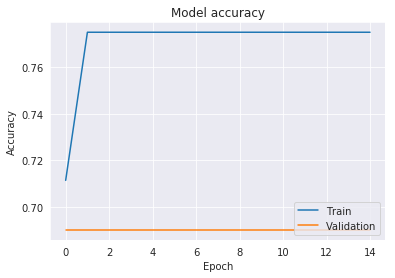

In [96]:
# model history is the resulting instance of the base model fit() function
# simple base model
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.show_history_accuracy(base_model_history)

**Note:**<br>
Regarding the result of the dataset V3 having a training-validation-testing distribution of 60-20-20:<br>
The training curve is much higher compared to the validation one, means overfitting exists. Both don't show a real learning during the epochs sequences. The final accuracy value is already reached with the first epoch. So, this model architecture doesn't fit to the classification task.

According [Neural Network  FAQ](ftp://ftp.sas.com/pub/neural/FAQ3.html#A_over) "Overfitting is especially dangerous because it can easily lead to predictions that are far beyond the range of the training data with many of the common types of NNs. Overfitting can also produce wild predictions in multilayer perceptrons even with noise-free data." In other words, with overfitting our predictions are not reliable. In the mentioned FAQ several reasons and approaches to avoid overfitting are mentioned.<br>
In this project as one consequence, we are using the augmentation concept to get much more training images which fits better to the amount of training parameters of the network, afterwards the Keras Adam optimiser with decay is used without and with augmentation.

But in general, it has been expected to have a better result with this modified dataset V3 which is not the case.


Base model with rmsprop optimiser and augmentation:


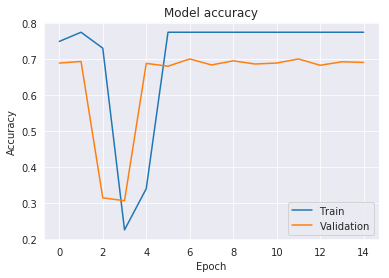

In [97]:
# augmented base model
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.show_history_accuracy(aug_base_model_history)

**Note:**<br>
The curve patterns are nearly the same for both, but there is still some overfitting.


Base model with Adam optimiser:


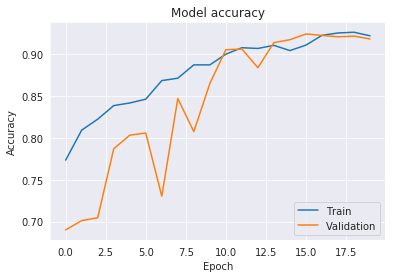

In [98]:
# base model with adam optimiser
print("\nBase model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(adam_base_model_history)

**Note:**<br>
The Adam optimiser showed a big improvement, but there is still some overfitting at the beginning up to epoch 10. Afterwards both are nearly the same.


Basic, augmented model with Adam optimiser:


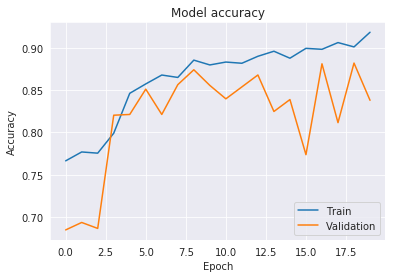

In [99]:
# base model with adam optimiser and augmentation
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(adam_aug_base_model_history)

**Note:**<br>
Using both concepts (Adam, augmentation) is not the best for this basic model executed on the modified dataset V3.


Improved model with Adam optimiser:


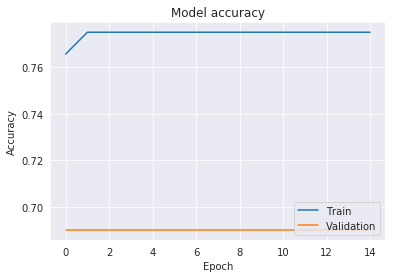

In [100]:
# improved model with adam optimiser
print("\nImproved model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(improved_model_history)


Improved, augmented model with Adam optimiser:


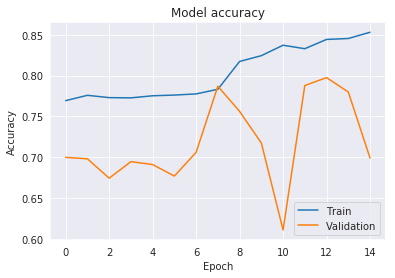

In [101]:
# improved, augmented model with adam optimiser
print("\nImproved, augmented model with Adam optimiser:")
Evaluation_Class.show_history_accuracy(improved_model_aug_history)


ResNet50 transfer model with Adam optimiser and bottleneck features:


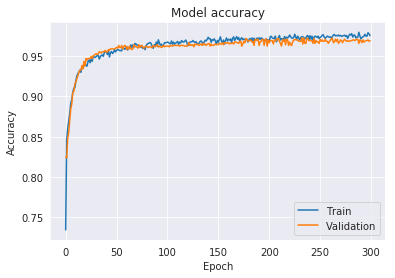

In [102]:
# ResNet50 transfer model
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_accuracy(resNet_transfer_model_history)

**Note:**<br>
With the RestNet50 transfer model using bottleneck features a fast high training accuracy appeared and the validation accuracy follows in the same way.


Fine-tuned ResNet50 transfer model with Adam optimiser and augmentation:


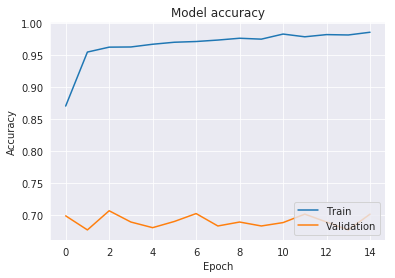

In [103]:
# Fine-tuned, augmented ResNet50 transfer  with adam optimiser
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and augmentation:")
Evaluation_Class.show_history_accuracy(resNet_finetuned_model_aug_history)

**Note:**<br>
This result showed that there is no general rule always having an accuracy improvement by using a fine-tuned transfer model.  A high overfitting exists during all the epochs.


InceptionV3 transfer model with Adam optimiser and bottleneck features:


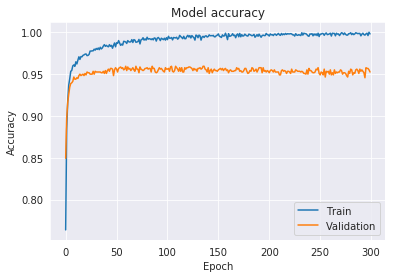

In [104]:
# InceptionV3 model with Adam optimiser and bottleneck features
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_accuracy(inception_transfer_model_history)

**Note:**<br>
A high accuracy appeared already for both datasets, but the validation does not follow in the same way as the training learned. There is some overfitting.

#### Learning during Training

Show the learning curves of loss function for training and validation.


Simple base model with rmsprop optimiser:


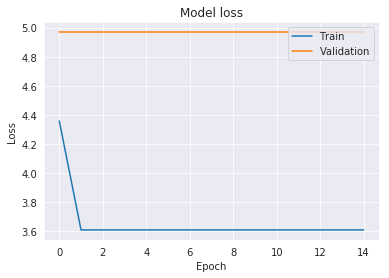

In [105]:
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.show_history_loss(base_model_history)

**Note:**<br>
In general, the training loss is the average of the losses over each batch of training data. There are 32 samples in each batch, which are processed independently. In general the model shall 'learn' over time, so regarding an epoch, at the beginning the learning loss value from the first batch is higher compared to the loss value of the final batch at the end. During validation, only the loss value of the epochs end is created, means a lower value shall exist. 

Modified dataset 60-20-20:<br>
We see overfitting: with epoch 1 for the training set and all epochs for the validation set the training is already complete, means both learning curves are mainly unchanged. Both diagrams show, that the model does not fit to the classification problem. In the next project parts using other dataset distributions, we will have a look, if the network architecture fits better.


Base model with rmsprop optimiser and augmentation:


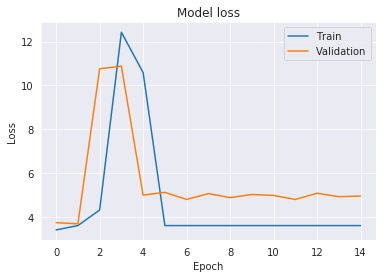

In [106]:
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.show_history_loss(aug_base_model_history)

**Note:**<br>
The learning curves have nearly the same pattern.


Base model with Adam optimiser:


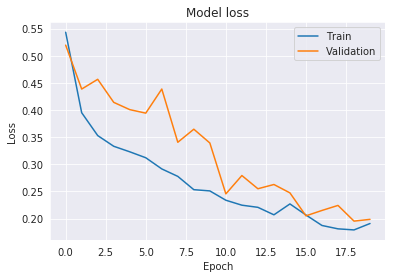

In [107]:
print("\nBase model with Adam optimiser:")
Evaluation_Class.show_history_loss(adam_base_model_history)

**Note:**<br>
Both curves are decreasing as expecting by using Adam optimiser. Starting with epoch 10 the curves draw near to each other.


Basic, augmented model with Adam optimiser:


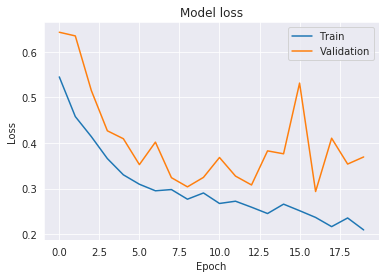

In [108]:
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.show_history_loss(adam_aug_base_model_history)


Improved model with Adam optimiser:


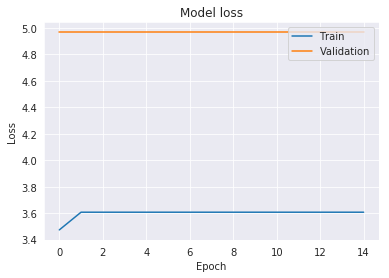

In [109]:
print("\nImproved model with Adam optimiser:")
Evaluation_Class.show_history_loss(improved_model_history)


Improved, augmented model with Adam optimiser:


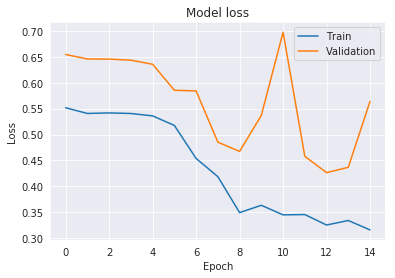

In [110]:
print("\nImproved, augmented model with Adam optimiser:")
Evaluation_Class.show_history_loss(improved_model_aug_history)


ResNet50 transfer model with Adam optimiser and bottleneck features:


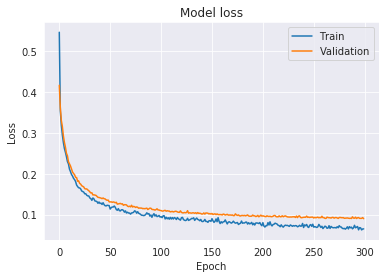

In [111]:
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_loss(resNet_transfer_model_history)

**Note:**<br>
Both learning curves show a smooth, constant loss value decrease with the biggest effect from the beginning up to epoch 50.


Fine-tuned ResNet50 transfer model with Adam optimiser and augmentation:


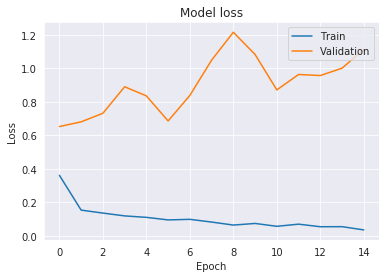

In [112]:
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and augmentation:")
Evaluation_Class.show_history_loss(resNet_finetuned_model_aug_history)

**Note:**<br>
The validation set learning loss increases mainly during the whole sequence, so, this model and its used parameters don't fit for the given distribution and the models classification task.


InceptionV3 transfer model with Adam optimiser and bottleneck features:


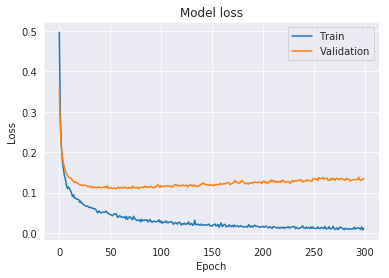

In [113]:
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.show_history_loss(inception_transfer_model_history)

**Note:**<br>
The learning for both datasets is nearly the same up to epoch 10, afterwards the validation curve is higher up to the epochs end and slowly increasing.

#### But first, some other metrics needed to compare all model results during the benchmark chapter ...

We need further metrics describing the performance, because a model may have a very good overall test accuracy, but the model is inadequate for the given classification task, because it is not taking care of the tasks domain properties. We would not realise this by using the overall accuracy value as only, single prediction metric.

**Precision** quantifies the binary precision. It is a ratio of true positives (images classified as pneumonia ones, and which are actually pneumonia) to all positives (all images classified as pneumonia ones, irrespective of whether that was the correct classification), in other words it is theratio of

TruePositives / (TruePositives + FalsePositives)

**Recall (sensitivity)** tells us what proportion of images that actually were pneumonia ones were classified by us as pneumonis ones. It is a ratio of true positives to all the images that were actually pneumonia ones, in other words it is the ratio of

TruePositives / (TruePositives + FalseNegatives)

A model's ability to precisely predict those that have a pneumonia is more important than the model's ability to recall those individuals. We can use **F-beta score** as a metric that considers both precision and recall. According scikit-learn, the F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. F – Measure is nothing but the harmonic mean of Precision and Recall.

Fβ=(1 + β2)  (precision⋅recall / ((β2⋅precision) + recall))

In particular, when β=0.5, more emphasis is placed on precision.

In [ ]:
# The scikit-learn metrics API expects a 1D array of actual and predicted values for comparison,
# therefore we must reduce the 2D target arrays to 1D arrays.
# How do the data arrays look like? 
#test_targets[:,1]
#chest_pneumonia_predictions

In [114]:
print("\nSimple base model with rmsprop optimiser:")
Evaluation_Class.get_other_metrics(test_targets, chest_pneumonia_predictions)


Simple base model with rmsprop optimiser:
Precision: 0.633
Recall: 1.000
F1 score: 0.775
F-beta score: 0.432  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 430]
 [  0 741]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Note:**<br>
According the sklearn documentation, the resulting values of 0 and the given _UndefinedMetricWarning_ show that there are vector elements of the _test_targets_ parameter which don't appear in the _chest_pneumonia_predictions_ parameter. Why is this here the case, it shouldn't be? But it can be realised, that this always happened, if the model architecture and the associated hyperparameters don't show a proper training and learning (see model accuracy and learning diagrams of the training and validation sets). So, such values are already a hint, that the model architecture with its used configuration doesn't fit for the classification task.

**Note:**<br>
Regarding this metrics some more explanations are necessary:

- **Cohen's Kappa**<br>
  Its value is a statistical measure of the  inter-rater agreement. It can be used to get information about the imbalance of the dataset.  Means in general, Cohen's Kappa takes the class distributions of the training data into account.
  

- **Confusion matrix**<br>
  In general, its architecture looks like
  ![confusion matrix](./images/ConfusionMatrix_architecture.png)

  It is a common method to get information about the classification performance.
  
  
- **Type 1 and Type 2 Errors**<br>
  There are two types of errors that can be identified here:

    Type 1 Error: The model predicted the instance to be a Positive class, but it is incorrect. This is False Positive (FP).<br>
    Type 2 Error: The model predicted the instance to be the Negative class, but it is incorrect. This is False Negative (FN).
    
    Having a medical diagnostic prediction task, this type 2 error is most important, because of its severe consequence for the patient, not getting the needed therapy and being unmedicated.
 
    
- **ROC AUC curves**<br>
  The ROC – Receiver Operating Characteristic - curve is a curve between true positive rate and false positive rate for various threshold values. So, it is telling us about the 2 types of errors for all thresholds.  The more the area under the curve (AUC), the better is the performance of our model to distinguish the classes. Means, it is a prediction probability curve for the different classes. It informs us how good or bad our overall model performance is, mapping the _conditional_ measures sensitivity and specificity into one value. The ROC AUC diagram is used to compare the different classifier models comparing it with a random option existing by chance and visualised by a diagonal, dotted line.

  A typical ROC curve has False Positive Rate (FPR) on the X-axis and True Positive Rate (TPR) on the Y-axis. And the ideal value for AUC is 1. In general, such best case scenario will not be reached, means we don't have a clear distinction between the two classes NORMAL and PNEUMONIA. In other words, we have some overlapping of the class predictions and that introduces Type 1 and Type 2 errors to the model prediction. As mentioned, the diagonal line visualises the random prediction.

In [115]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = base_model.predict(test_tensors, verbose=0)  # arrays of chest normal and pneumonia probabilities
#yhat_probs
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) # pneumonia probability values
print('ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser: 0.493


In our case, we are looking to the 'positive' Pneumonia class. So, how does the ROC AUC diagram looks like to the given ROC AUC value above?

--- associated ROC AUC diagram of model type Basic CNN Model ---


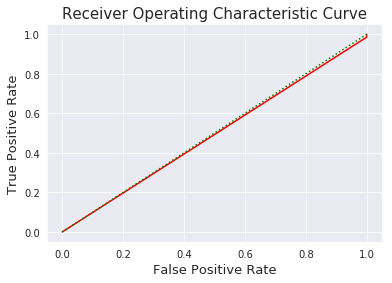

In [116]:
# see:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
# plot ROC Curve using the defined function
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model")

**Note:**<br>
The ROC AUC curve is a little bit worse one compared to the random, green dotted line which appeared by chance.

In [117]:
print("\nBase model with rmsprop optimiser and augmentation:")
Evaluation_Class.get_other_metrics(test_targets, aug_chest_pneumonia_predictions)



Base model with rmsprop optimiser and augmentation:
Precision: 0.633
Recall: 1.000
F1 score: 0.775
F-beta score: 0.432  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 430]
 [  0 741]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [118]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = aug_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser and augmentation: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with rmsprop optimiser and augmentation: 0.238


--- associated ROC AUC diagram of model type Basic CNN Model with Augmentation ---


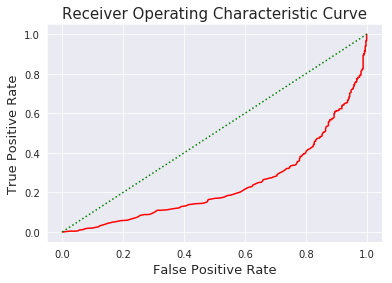

In [119]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model with Augmentation")

In [120]:
print("\nBase model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, adam_chest_pneumonia_predictions)



Base model with Adam as optimiser:
Precision: 0.882
Recall: 0.950
F1 score: 0.915
F-beta score: 0.887  with beta=0.5

Cohens kappa: 0.752
Confusion matrix of the test data:
[[336  94]
 [ 37 704]]


In [121]:
# ROC AUC
# predict probabilities for the test set
yhat_probs = adam_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(y_true=test_targets[:,1], y_score=yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic model with Adam optimiser: 0.952


--- associated ROC AUC diagram of model type Basic CNN Model with Adam optimiser ---


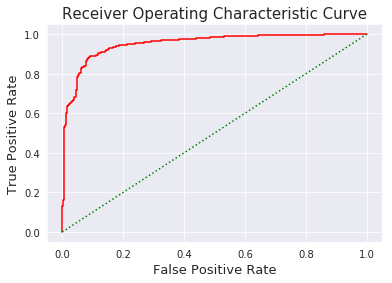

In [122]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Basic CNN Model with Adam optimiser")

In [123]:
print("\nBasic, augmented model with Adam optimiser:")
Evaluation_Class.get_other_metrics(test_targets, adam_aug_chest_pneumonia_predict)



Basic, augmented model with Adam optimiser:
Precision: 0.910
Recall: 0.923
F1 score: 0.916
F-beta score: 0.893  with beta=0.5

Cohens kappa: 0.769
Confusion matrix of the test data:
[[362  68]
 [ 57 684]]


In [124]:
# ROC AUC
# predict probabilities for test set
yhat_probs = adam_aug_base_model.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of basic, augmented model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of basic, augmented model with Adam optimiser: 0.957


--- associated ROC AUC diagram of model type Basic CNN Model with Adam optimiser and Augmentation ---


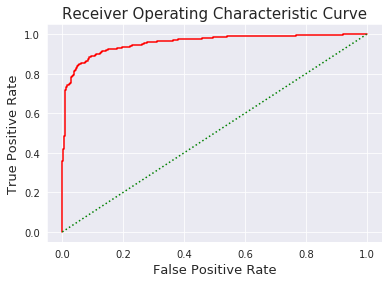

In [125]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                              modelname="Basic CNN Model with Adam optimiser and Augmentation")

In [126]:
print("\nImproved model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, improved_chest_pneumonia_predict_adam)



Improved model with Adam as optimiser:
Precision: 0.633
Recall: 1.000
F1 score: 0.775
F-beta score: 0.432  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 430]
 [  0 741]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [129]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_adam.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1])
print('ROC AUC Pneumonia class prediction of improved model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of improved model with Adam optimiser: 0.500


--- associated ROC AUC diagram of model type Improved CNN Model with Adam optimiser ---


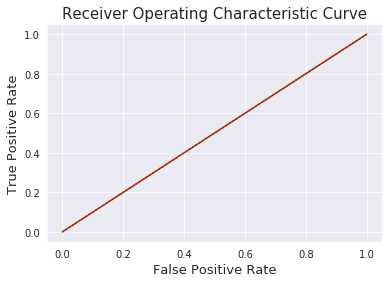

In [130]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr, modelname="Improved CNN Model with Adam optimiser")

**Note:**<br>
The own created 'improved' labelled model architecture using convolutional layers with the used hyperparameters has the same prediction as it exits by chance.

In [131]:
print("\nImproved, augmented model with Adam as optimiser:")
Evaluation_Class.get_other_metrics(test_targets, improved_chest_pneumonia_predict_aug)



Improved, augmented model with Adam as optimiser:
Precision: 0.746
Recall: 0.897
F1 score: 0.815
F-beta score: 0.730  with beta=0.5

Cohens kappa: 0.401
Confusion matrix of the test data:
[[204 226]
 [ 76 665]]


**Note:**<br>
The confusion matrix shows an unacceptable high value of false negatives: 60.

In [132]:
# ROC AUC
# predict probabilities for test set
yhat_probs = improved_model_aug.predict(test_tensors, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of improved, augmented model with Adam optimiser: 0.851


--- associated ROC AUC diagram of model type Improved CNN Model with Adam optimiser and Augmentation ---


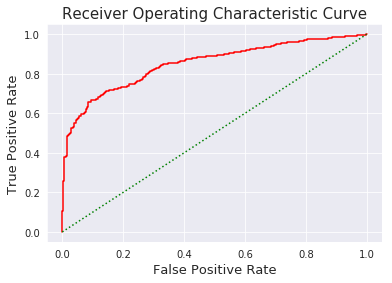

In [133]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                              modelname="Improved CNN Model with Adam optimiser and Augmentation")

In [134]:
print("\nResNet50 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.get_other_metrics(test_targets, resNet_chest_pneumonia_predict)



ResNet50 transfer model with Adam optimiser and bottleneck features:
Precision: 0.810
Recall: 0.993
F1 score: 0.892
F-beta score: 0.851  with beta=0.5

Cohens kappa: 0.644
Confusion matrix of the test data:
[[257 173]
 [  5 736]]


In [135]:
# ROC AUC
# predict probabilities for test set
yhat_probs = basic_resNet_model.predict(test_resNet, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of ResNet50 transfer model with Adam optimiser and bottleneck features: %.3f' % auc)

ROC AUC Pneumonia class prediction of ResNet50 transfer model with Adam optimiser and bottleneck features: 0.954


--- associated ROC AUC diagram of model type CNN Model with ResNet50 transfer learning, Adam optimiser and bottleneck features ---


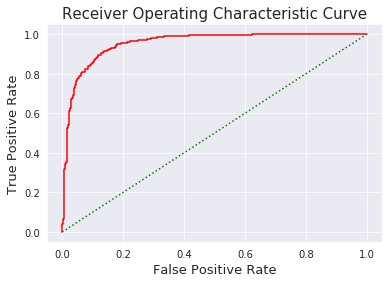

In [137]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
                           modelname="CNN Model with ResNet50 transfer learning, Adam optimiser and bottleneck features")

In [138]:
print("\nFine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:")
Evaluation_Class.get_other_metrics(test_targets, resNet_ft_transfer_chest_pneumonia_predict)



Fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation:
Precision: 0.633
Recall: 1.000
F1 score: 0.775
F-beta score: 0.432  with beta=0.5

Cohens kappa: 0.000
Confusion matrix of the test data:
[[  0 430]
 [  0 741]]


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [139]:
# ROC AUC
# predict probabilities for test set
yhat_probs = resNet_ft_model.predict(test_tensors, verbose=0) 
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation: %.3f' % auc)

ROC AUC Pneumonia class prediction of fine-tuned ResNet50 transfer model with Adam optimiser and Augmentation: 0.152


--- associated ROC AUC diagram of model type CNN Model with fine-tuned ResNet50 transfer learning, Adam optimiser and Augmentation ---


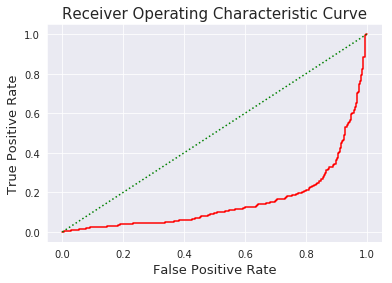

In [140]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
             modelname="CNN Model with fine-tuned ResNet50 transfer learning, Adam optimiser and Augmentation")

**Note:**<br>
It seemed as if a general conclusion that fine-tuned transfer learning models specific for image classification, like the ResNet50 architecture, used with augmentation are always a very good solution for the given image classification task is wrong. By now, it is unclear if the training get stucked in a local minimum or if the chosen model and the selected parameters are simply not optimal and don't fit.
As a future open topic, this could be evaluated more precisly by changing the parameters, always having in mind that the sample distribution has a big effect on the training result of the models (see future to do comment of the last project chapter).

Compared to the ResNet transfer model used with bottleneck features this fine-tuned one with augmentation is exactly the oposite of very good. E.g. the ROC AUC value is nearly as bad as the one of the basic model from scratch with rmsprop optimiser. Both are worth than the random case (green dotted line). 

By now, we will have a look if there is at least one possible pre-trained transfer learning model that leads to better training results - the Inception3 model. We use it with bottleneck features.

In [141]:
print("\nInceptionV3 transfer model with Adam optimiser and bottleneck features:")
Evaluation_Class.get_other_metrics(test_targets, inception_chest_pneumonia_predict)



InceptionV3 transfer model with Adam optimiser and bottleneck features:
Precision: 0.822
Recall: 0.978
F1 score: 0.893
F-beta score: 0.853  with beta=0.5

Cohens kappa: 0.659
Confusion matrix of the test data:
[[273 157]
 [ 16 725]]


In [142]:
# ROC AUC
# predict probabilities for test set
yhat_probs = inception_model.predict(test_inception, verbose=0)  
auc = metrics.roc_auc_score(test_targets[:,1], yhat_probs[:,1]) 
print('ROC AUC Pneumonia class prediction of InceptionV3 transfer model with Adam optimiser: %.3f' % auc)

ROC AUC Pneumonia class prediction of InceptionV3 transfer model with Adam optimiser: 0.957


--- associated ROC AUC diagram of model type CNN Model with InceptionV3 transfer learning with Adam optimiser and Augmentation ---


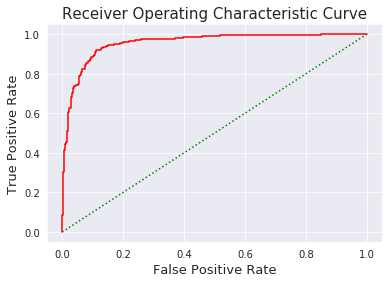

In [143]:
fpr, tpr, threshold = metrics.roc_curve(y_true=test_targets[:,1], y_score=yhat_probs[:,1])
Evaluation_Class.plot_ROC_AUC(fpr=fpr, tpr=tpr,
             modelname="CNN Model with InceptionV3 transfer learning with Adam optimiser and Augmentation")

<a id='step14'></a>
## Step 14: Benchmark and Conclusion

Regarding the different evaluation results according test accuracy and because having a medical diagnosis prediction task the number of false negatives, it can be realised that 2 different models can be chosen for the classification issue of this given original data distribution.

If it is decided to have a higher prio on the lowest number of false negatives (type 2 error), the ResNet50 transfer model with Adam optimiser and bottleneck features - having only 5 false negatives and a test accuracy of 84.80%.

If the decision is taken to have the model with the highest test accuracy, then the Basic Model with Adam optimiser and Augmentation should be chosen: Its value is 89.33%. But is has detected 57 false negatives, which is too much.

Another insight of this evaluation is, that using a fine-tuned transfer learning model architecture with augmentation is no general, overall guarantee of having a better performance.

An overall description of the benchmark and conclusion, e.g. reagarding the insights by comparing all the models with the different distributions, is given in the final project document.

As a **future to do:** Better hyperparameter values must be found by having a better environment for machine learning algorithms (batch and epoch sizes together with the initialisation, changing learning rate and early stopping). My own hardware (not made for machine learning tasks) needed a whole week to do the calculations of this file and the local internet environment of the provider is an old standard compared to the one of the Silicon Valley and it is unstable. Means the AWS EC2 service has been disconnected few times a week and a lot of restarts were necessary. If the AWS service connection worked fine, the caculations of this file with random started hyperparameters needed approximately 2 days to be finished. So, hyperparameter tuning from Scikit-Learn with GridSearchCV or RandomizedCV as an alternative has not been done, because it is computational expensive having such a lot of parameters for the neural networks. With neural network optimisation, it is expected to get better prediction results.

As already mentioned, having more pneumonia chest images with further root causes (not only virus and bacteria root causes exist), the algorithm can be improved doing a multi-class classification between normal and pneumonia ones, where the pneumonia ones are differentiated by their root cause from the scratch.<br>
The same is valid by including the whole variety of ages, because this dataset is focussed on children images.

Furthermore, because of project deadline, the applicational algorithm accepting a file path to an unknown, future X-ray .jpg image and determine if it is a pneumonia image or not together with its testing code, has not been implemented yet. This would be possible, e.g. by usage of the [skimage](https://scikit-image.org/docs/dev/api/api.html) package or the [OpenCV cv2](https://docs.opencv.org/trunk/index.html) implementation.